In [1]:
# !pip install prettytable

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
from flaml import AutoML
from sklearn.ensemble import HistGradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor

from lightgbm import LGBMRegressor
from prettytable import PrettyTable
import sys  
import os
root_path = os.path.realpath('/..')
sys.path.insert(0, root_path)
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

from tw_experimentation.variance_reduction.diff_in_means import DifferenceInMeans
from tw_experimentation.variance_reduction.cuped import CUPED, multiple_CUPEDs, MultivariateCUPED
from tw_experimentation.variance_reduction.utils import create_pretty_table, query_snowflake, bootstrap_generator, subsample_generator, bootstrap_data, subsample_data, aaify, add_synthetic_effect, diff_in_means
from tw_experimentation.variance_reduction.mlrate import MLRATE, AltMLRATE
from tw_experimentation.variance_reduction.cupac import CUPAC
from tw_experimentation.variance_reduction.doubly_robust import DoublyRobustEstimator
from tw_experimentation.variance_reduction.evaluation_pipeline import VREvaluation, VREvaluationAll
from tw_experimentation.variance_reduction.multivariate_regression import MultivariateRegression, MultivariateRegressionAdjusted


## Simple synthetic data

In [3]:
def generate_synthetic_data(n):

    # pre experiment metric
    group_0 = np.random.exponential(10, n//2)
    group_1 = np.random.exponential(10, n//2)

    pre_metric = np.concatenate([group_0, group_1])

    # experiment metric
    ctrl_group_0 = group_0 + np.random.normal(0,1, n//2)
    treatment_group_1 = group_1 + np.random.normal(5,1, n//2) + np.random.normal(0,1, n//2)

    exp_metric = np.concatenate([ctrl_group_0, treatment_group_1])

    # treatment
    treatment = np.concatenate([np.zeros(n//2), np.ones(n//2)])

    # assemble dataframe
    df = pd.DataFrame({
        'exp_metric': exp_metric,
        'treatment': treatment,
        'pre_metric': pre_metric
    })

    # shuffle
    df = df.sample(frac=1).reset_index(drop=True)

    return df


In [4]:
simple_synthetic_df = generate_synthetic_data(10000)

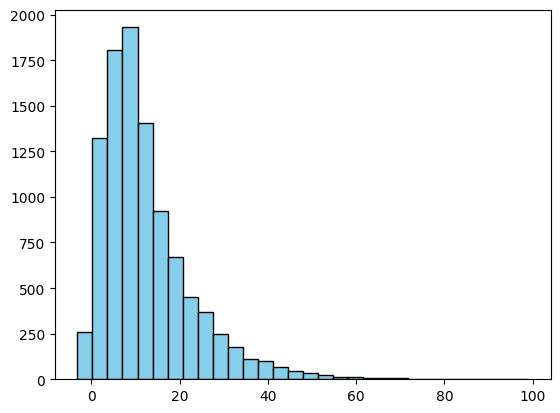

In [5]:
plt.hist(simple_synthetic_df['exp_metric'], bins=30, color='skyblue', edgecolor='black')
plt.show()

## Evaluation on simple synthetic data

In [6]:
method_params_map = {

    'DifferenceInMeans': {
    },
    
    'CUPED': {
        'covariate_column': 'pre_metric'
    },

    'MultivariateRegression': {
        'covariate_columns': ['pre_metric']
    },

    'MultivariateRegressionAdjusted': {
        'covariate_columns': ['pre_metric']
    },

    # 'CUPAC': {
    #     'pre_experiment_data': 'ml_synthetic_df',
    #     'covariate_columns': list(ml_synthetic_df.columns[2:10]),
    #     'model': HistGradientBoostingRegressor,
    #     'model_init_config': {},
    #     'model_fit_config': {}
    # },

    'MLRATE': {
        'K_splits': 2,
        'covariate_columns': ['pre_metric'],
        'model': ElasticNet,
        'model_init_config': {},
        'model_fit_config': {}
    },

    'DoublyRobustEstimator': {
        'covariate_columns': ['pre_metric']
    }

}

In [7]:
evaluator_all = VREvaluationAll([DifferenceInMeans, MultivariateRegression, MultivariateRegressionAdjusted, CUPED, MLRATE, DoublyRobustEstimator])

In [8]:
evaluator_all = evaluator_all.run_all(data=simple_synthetic_df,
                                        treatment_column='treatment',
                                        target_column='exp_metric',
                                        method_params_map=method_params_map,
                                        verbose=True,
                                        n_bootstrap=100,
                                        true_ate=5)
                                  

Running DifferenceInMeans...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 388.28it/s]


Running MultivariateRegression...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 134.44it/s]


Running MultivariateRegressionAdjusted...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 115.96it/s]


Running CUPED...


 10%|████▏                                     | 10/100 [00:00<00:00, 97.37it/s]

[2.49635307 1.0001438 ]
[2.5567593  0.99450384]
[2.5154704  0.99803364]
[2.54962474 0.99571819]
[2.50158879 0.99880651]
[2.48605614 0.99912007]
[2.47140022 1.00277085]
[2.52790008 0.99801514]
[2.52487601 0.998011  ]
[2.50828422 0.99892837]
[2.51804384 0.99817916]
[2.51589446 0.99732525]
[2.48269144 0.99897124]
[2.56895777 0.99203909]
[2.47239691 1.00045132]
[2.53585108 0.99714472]
[2.50261859 1.0018178 ]
[2.55458549 0.99256471]
[2.49084506 0.99939891]
[2.52632316 0.99911675]


 30%|████████████▌                             | 30/100 [00:00<00:00, 95.63it/s]

[2.55556734 0.99393163]
[2.55823502 0.99355611]
[2.54685999 0.99411018]
[2.556186   0.99574468]
[2.51291643 0.99797668]
[2.61003799 0.99012236]
[2.52693506 0.99636112]
[2.49156624 1.00027177]
[2.52890869 0.99826317]
[2.46680479 1.00106822]
[2.57677162 0.99443994]
[2.55541666 0.99303512]
[2.51257308 0.99832674]
[2.54719196 0.99601029]
[2.51547835 0.99843092]
[2.52967224 0.99649306]
[2.55714706 0.99570214]
[2.53141234 0.99637195]
[2.56515335 0.9952094 ]
[2.55706978 0.99561439]


 50%|█████████████████████                     | 50/100 [00:00<00:00, 96.04it/s]

[2.53449829 0.99632579]
[2.51270362 0.99710992]
[2.58711018 0.99201586]
[2.55266392 0.99246767]
[2.56999155 0.99039102]
[2.50223765 1.00107977]
[2.53660905 0.99591495]
[2.56871339 0.9924886 ]
[2.52661125 0.99731024]
[2.54593215 0.9941671 ]
[2.54443531 0.99573799]
[2.54177904 0.9957259 ]
[2.52402353 0.99628861]
[2.58023546 0.99217644]
[2.53138824 0.99590715]
[2.47709787 0.99990051]
[2.46601065 1.00154531]
[2.56390143 0.99352602]
[2.59103819 0.99288614]
[2.50767504 0.99839245]


 70%|█████████████████████████████▍            | 70/100 [00:00<00:00, 94.87it/s]

[2.50912655 0.99837109]
[2.5355567  0.99668746]
[2.49816427 1.00016385]
[2.50426683 0.99979447]
[2.51988106 0.9973767 ]
[2.57339582 0.99348078]
[2.52637247 0.99701562]
[2.55363351 0.99594593]
[2.52163198 0.99640427]
[2.50228995 0.99867199]
[2.54378434 0.9959698 ]
[2.49908685 0.99914672]
[2.5141012  0.99707397]
[2.51539732 0.9990913 ]
[2.56668771 0.99338521]
[2.5509894  0.99347993]
[2.51933026 0.99715966]
[2.51497954 0.99690138]
[2.51040116 0.99898196]
[2.51951542 0.99894816]


 90%|█████████████████████████████████████▊    | 90/100 [00:00<00:00, 96.19it/s]

[2.54673856 0.99522924]
[2.5619114  0.99508321]
[2.56415857 0.99232443]
[2.51210606 0.9976169 ]
[2.50387868 0.99980304]
[2.55236065 0.99601299]
[2.5531282  0.99499096]
[2.55658107 0.99599208]
[2.55406129 0.99440054]
[2.58391498 0.99338622]
[2.54277613 0.99372977]
[2.55665427 0.99413737]
[2.497075   0.99860056]
[2.56788759 0.99171709]
[2.51407426 0.99784535]
[2.4941082  1.00013956]
[2.50130567 0.99952764]
[2.5344817  0.99469784]
[2.53874661 0.99491625]
[2.52864845 0.99704453]


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 96.22it/s]


Running MLRATE...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 61.43it/s]


Running DoublyRobustEstimator...


100%|█████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]

Done!


In [9]:
evaluator_all.report()

,Method,Estimate,Estimate CI,Bias,Bias CI,p-value,p-value CI,Coverage Probability,Variance Reduction
0,DifferenceInMeans,4.849366,"(4.510782071798092, 5.165893266907868)",-0.150634,"(-0.4892179282019083, 0.1658932669078683)",0.0,"(3.2438563798369136e-139, 5.18854132474004e-106)",0.00,0.000000
1,MultivariateRegression,5.025996,"(4.980837074370074, 5.070472601227568)",0.025996,"(-0.019162925629926362, 0.07047260122756757)",0.0,"(0.0, 0.0)",0.83,0.983684
2,MultivariateRegressionAdjusted,5.026009,"(4.980840017457344, 5.070452465021174)",0.026009,"(-0.01915998254265587, 0.07045246502117414)",0.0,"(0.0, 0.0)",0.83,0.983684
3,CUPED,5.025200,"(4.980705800210049, 5.069170128669897)",0.025200,"(-0.01929419978995097, 0.06917012866989666)",0.0,"(0.0, 0.0)",0.83,0.983769
4,MLRATE,5.027048,"(4.983074082356125, 5.071843877908454)",0.027048,"(-0.016925917643875365, 0.07184387790845372)",0.0,"(0.0, 0.0)",0.83,0.983724
5,DoublyRobustEstimator,5.004700,"(4.955191021292431, 5.050984227611341)",0.004700,"(-0.04480897870756899, 0.05098422761134133)",None,None,0.98,0.977255


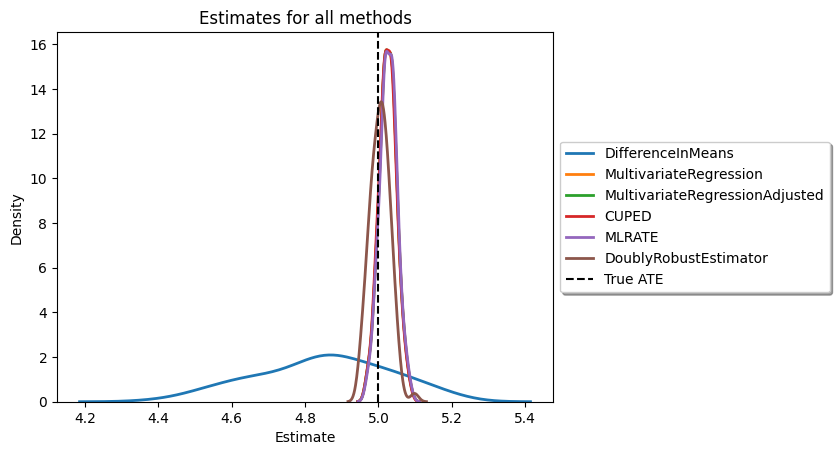

<Axes: title={'center': 'Estimates for all methods'}, xlabel='Estimate', ylabel='Density'>

In [10]:
evaluator_all.plot(plot_what='estimates')

# Granular investigation

## Synthetic data with linear relationship between covariate and target

### Linear methods

In [11]:
simple_synthetic_df = generate_synthetic_data(10000)

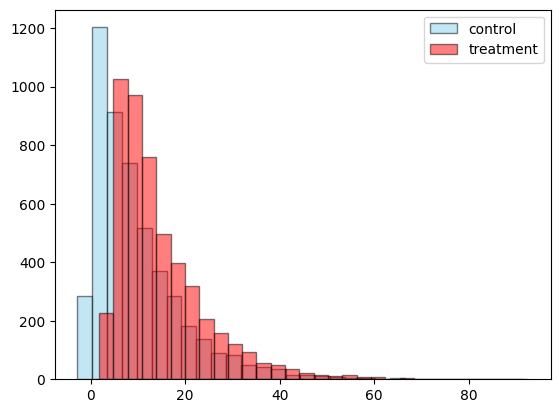

In [12]:
# plot histogram of the experiment metric stratifying by treatment
plt.hist(simple_synthetic_df.loc[simple_synthetic_df.treatment == 0, 'exp_metric'], bins=30, color='skyblue', edgecolor='black', alpha=0.5, label='control')
plt.hist(simple_synthetic_df.loc[simple_synthetic_df.treatment == 1, 'exp_metric'], bins=30, color='red', edgecolor='black', alpha=0.5, label='treatment')
plt.legend()
plt.show()

In [13]:
evaluation_linear_method = VREvaluationAll([DifferenceInMeans,
                                            MultivariateRegression,
                                            MultivariateRegressionAdjusted,
                                            CUPED])

In [14]:
linear_params_map = {
    'DifferenceInMeans': {
    },

    'MultivariateRegression': {
        'covariate_columns': ['pre_metric']
    },

    'MultivariateRegressionAdjusted': {
        'covariate_columns': ['pre_metric']
    },

    'CUPED': {
        'covariate_column': 'pre_metric'
    }
}

In [15]:
evaluation_linear_method = evaluation_linear_method.run_all(data=simple_synthetic_df,
                                                            treatment_column='treatment',
                                                            target_column='exp_metric',
                                                            method_params_map=linear_params_map,
                                                            verbose=True,
                                                            n_bootstrap=100,
                                                            true_ate=5)

Running DifferenceInMeans...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 390.11it/s]


Running MultivariateRegression...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 129.60it/s]


Running MultivariateRegressionAdjusted...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 114.11it/s]


Running CUPED...


 11%|████▌                                    | 11/100 [00:00<00:00, 101.27it/s]

[2.48086009 1.00099381]
[2.54464821 0.99428267]
[2.50880162 0.99652961]
[2.47448191 0.99938793]
[2.50922758 0.99970093]
[2.41651882 1.00598824]
[2.54522333 0.99524257]
[2.45162514 1.00316576]
[2.47063366 1.00224715]
[2.47992508 0.99958148]
[2.53334621 0.99497414]
[2.56139892 0.99480983]
[2.48669389 0.99954263]
[2.4774066 1.0001434]
[2.50735429 0.99767164]
[2.48608731 1.00073805]
[2.45758786 1.00264633]
[2.46727146 1.00131755]
[2.50981292 0.99866513]
[2.49319868 0.99857084]
[2.55884916 0.99352336]


 32%|█████████████▍                            | 32/100 [00:00<00:00, 98.77it/s]

[2.45589557 1.00290961]
[2.54876728 0.99443118]
[2.5108601  0.99838557]
[2.47085955 1.00241484]
[2.52270457 0.99771554]
[2.45871502 1.00006368]
[2.52602429 0.99528788]
[2.49762886 0.99880465]
[2.50399586 1.00015595]
[2.49560818 0.99695745]
[2.46547028 1.00166999]
[2.46017341 1.00159058]
[2.51565889 0.99742192]
[2.52892107 0.99438146]
[2.44765477 1.00440609]
[2.48497325 1.00187004]
[2.46729087 1.00013324]
[2.48598189 0.99980923]
[2.48016442 0.99907186]
[2.47897908 1.0016835 ]


 52%|█████████████████████▊                    | 52/100 [00:00<00:00, 97.58it/s]

[2.50552863 0.99629375]
[2.46439004 1.0021472 ]
[2.47952859 1.00093605]
[2.4846223  1.00242108]
[2.53091704 0.99678628]
[2.50104559 0.99740015]
[2.53021679 0.99525266]
[2.50419721 0.99885893]
[2.47347259 1.00128636]
[2.46129793 1.00062442]
[2.56699419 0.99100773]
[2.54976529 0.99632499]
[2.50932604 0.99917151]
[2.4804979  0.99924848]
[2.4359836  1.00703508]
[2.51620035 0.99682783]
[2.50349776 1.00022434]
[2.48463061 1.00000713]
[2.40228411 1.00682975]
[2.46260099 1.00272372]


 72%|██████████████████████████████▏           | 72/100 [00:00<00:00, 97.55it/s]

[2.55376077 0.99398286]
[2.49058503 0.99939156]
[2.46322576 1.00191832]
[2.46537452 1.00041088]
[2.52138304 0.99560232]
[2.44679848 1.00366755]
[2.50088402 0.99670085]
[2.47438539 1.00259447]
[2.48554707 0.99885839]
[2.50957164 0.99803354]
[2.51872109 0.9957535 ]
[2.39726557 1.00868807]
[2.51640761 0.99550496]
[2.52005907 0.998403  ]
[2.47636069 1.00110679]
[2.46387974 1.00176954]
[2.45848223 1.00089712]
[2.48691866 1.00183157]
[2.50327309 0.99799015]


 92%|██████████████████████████████████████▋   | 92/100 [00:00<00:00, 95.37it/s]

[2.49631473 0.99812911]
[2.53379109 0.99609631]
[2.41988724 1.00476036]
[2.50810733 0.99654418]
[2.50603262 0.9975356 ]
[2.48944027 0.99844666]
[2.48077554 1.00115382]
[2.47526861 1.00085714]
[2.5085287  0.99716683]
[2.51348075 0.99537038]
[2.56707633 0.99383999]
[2.41475907 1.00493053]
[2.54836415 0.9950951 ]
[2.39368212 1.00852831]
[2.49270368 0.99773334]
[2.48949663 1.00079376]
[2.48615367 1.00042614]
[2.51030358 0.99595016]
[2.5254351  0.99498667]


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 96.91it/s]

[2.44677743 1.0043623 ]
Done!


In [16]:
evaluation_linear_method.report()

,Method,Estimate,Estimate CI,Bias,Bias CI,p-value,p-value CI,Coverage Probability,Variance Reduction
0,DifferenceInMeans,4.970220,"(4.521661070615107, 5.398414123017647)",-0.029780,"(-0.47833892938489386, 0.39841412301764634)",5.685519e-108,"(4.332434958348936e-159, 1.4435349726969226e-112)",0.00,0.000000
1,MultivariateRegression,5.021300,"(4.972838097091501, 5.063779603086824)",0.021300,"(-0.027161902908498625, 0.06377960308682404)",0.000000e+00,"(0.0, 0.0)",0.82,0.988620
2,MultivariateRegressionAdjusted,5.021304,"(4.972840332416334, 5.063766872709284)",0.021304,"(-0.02715966758366566, 0.06376687270928358)",0.000000e+00,"(0.0, 0.0)",0.82,0.988622
3,CUPED,5.020613,"(4.972443873578271, 5.062155370306342)",0.020613,"(-0.027556126421728843, 0.062155370306341766)",0.000000e+00,"(0.0, 0.0)",0.83,0.988573


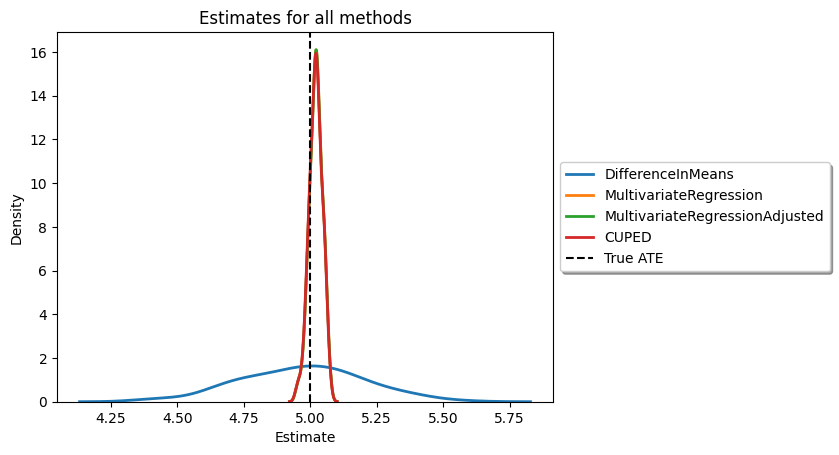

<Axes: title={'center': 'Estimates for all methods'}, xlabel='Estimate', ylabel='Density'>

In [17]:
evaluation_linear_method.plot(plot_what='estimates')

In [18]:
bootstrapped_diff_in_means = []
for b_sample in evaluation_linear_method.bootstrap_samples:

    b_data = simple_synthetic_df.iloc[b_sample]
    b_dim = b_data.loc[b_data['treatment'] == 1, 'exp_metric'].mean() - b_data.loc[b_data['treatment'] == 0, 'exp_metric'].mean()

    bootstrapped_diff_in_means.append(b_dim)

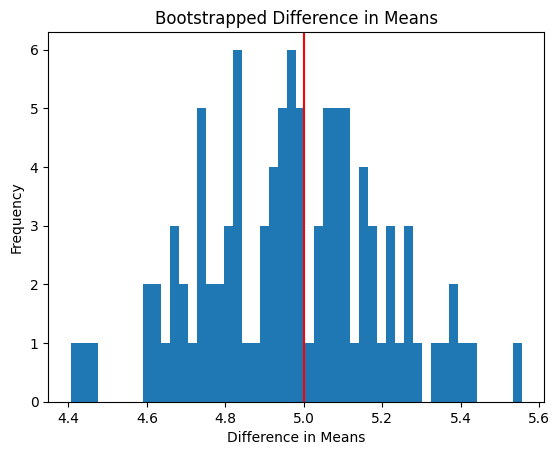

In [19]:
# plot a histogram of bootstrapped_diff_in_means

plt.hist(bootstrapped_diff_in_means, bins=50)
# add a vertical at 5 with label true ATE
plt.axvline(x=5, color='red', label='True ATE')
plt.title('Bootstrapped Difference in Means')
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')
plt.show()


### CUPAC

In [20]:
pre_exp_simple_synthetic_df = generate_synthetic_data(5000)
pre_exp_simple_synthetic_df = pre_exp_simple_synthetic_df.loc[pre_exp_simple_synthetic_df['treatment'] == 0]

In [21]:
cupac_params_map = {
    'CUPAC': {
        'pre_experiment_data': pre_exp_simple_synthetic_df,
        'covariate_columns': ['pre_metric'],
        'model': ExtraTreesRegressor,
        'model_init_config': {},
        'model_fit_config': {
        }
    }
}


In [22]:
evaluation_cupac = VREvaluation(CUPAC)

In [23]:
evaluation_cupac = evaluation_cupac.run(data=simple_synthetic_df,
                                        treatment_column='treatment',
                                        target_column='exp_metric',
                                        method_params_map=cupac_params_map,
                                        verbose=True,
                                        n_bootstrap=100,
                                        true_ate=5)

Running CUPAC...


  1%|▍                                          | 1/100 [00:00<00:27,  3.65it/s]

[2.51223941 0.99695678]


  2%|▊                                          | 2/100 [00:00<00:27,  3.61it/s]

[2.51778987 0.99595423]


  3%|█▎                                         | 3/100 [00:00<00:27,  3.58it/s]

[2.53377785 0.99327164]


  4%|█▋                                         | 4/100 [00:01<00:26,  3.59it/s]

[2.55485319 0.99248845]


  5%|██▏                                        | 5/100 [00:01<00:26,  3.60it/s]

[2.5634446  0.99117464]


  6%|██▌                                        | 6/100 [00:01<00:26,  3.59it/s]

[2.4528274  1.00341673]


  7%|███                                        | 7/100 [00:01<00:25,  3.60it/s]

[2.53854634 0.99269138]


  8%|███▍                                       | 8/100 [00:02<00:25,  3.62it/s]

[2.53641203 0.99291235]


  9%|███▊                                       | 9/100 [00:02<00:25,  3.63it/s]

[2.61030061 0.98760259]


 10%|████▏                                     | 10/100 [00:02<00:24,  3.64it/s]

[2.5551544  0.99438646]


 11%|████▌                                     | 11/100 [00:03<00:24,  3.62it/s]

[2.51129093 0.99637312]


 12%|█████                                     | 12/100 [00:03<00:24,  3.62it/s]

[2.57448916 0.9903267 ]


 13%|█████▍                                    | 13/100 [00:03<00:24,  3.62it/s]

[2.55446287 0.99515017]


 14%|█████▉                                    | 14/100 [00:03<00:23,  3.63it/s]

[2.55910021 0.99412427]


 15%|██████▎                                   | 15/100 [00:04<00:23,  3.64it/s]

[2.56613128 0.99148659]


 16%|██████▋                                   | 16/100 [00:04<00:23,  3.62it/s]

[2.47749015 0.99940946]


 17%|███████▏                                  | 17/100 [00:04<00:22,  3.62it/s]

[2.52548889 0.9946427 ]


 18%|███████▌                                  | 18/100 [00:04<00:22,  3.63it/s]

[2.53849897 0.99649932]


 19%|███████▉                                  | 19/100 [00:05<00:22,  3.62it/s]

[2.55133959 0.9943267 ]


 20%|████████▍                                 | 20/100 [00:05<00:22,  3.63it/s]

[2.54405213 0.9948653 ]


 21%|████████▊                                 | 21/100 [00:05<00:21,  3.63it/s]

[2.58622186 0.98728769]


 22%|█████████▏                                | 22/100 [00:06<00:21,  3.63it/s]

[2.45460329 0.99987352]


 23%|█████████▋                                | 23/100 [00:06<00:21,  3.61it/s]

[2.53613065 0.99173295]


 24%|██████████                                | 24/100 [00:06<00:20,  3.62it/s]

[2.58123474 0.99071146]


 25%|██████████▌                               | 25/100 [00:06<00:20,  3.63it/s]

[2.57555823 0.99034602]


 26%|██████████▉                               | 26/100 [00:07<00:20,  3.63it/s]

[2.58272288 0.99046988]


 27%|███████████▎                              | 27/100 [00:07<00:20,  3.64it/s]

[2.47087694 1.00119643]


 28%|███████████▊                              | 28/100 [00:07<00:19,  3.65it/s]

[2.52234205 0.99594965]


 29%|████████████▏                             | 29/100 [00:08<00:19,  3.63it/s]

[2.57507671 0.99024268]


 30%|████████████▌                             | 30/100 [00:08<00:19,  3.61it/s]

[2.5761251  0.99078222]


 31%|█████████████                             | 31/100 [00:08<00:19,  3.55it/s]

[2.4976713 0.9940273]


 32%|█████████████▍                            | 32/100 [00:08<00:19,  3.51it/s]

[2.55322241 0.99236105]


 33%|█████████████▊                            | 33/100 [00:09<00:18,  3.53it/s]

[2.48996003 0.99691244]


 34%|██████████████▎                           | 34/100 [00:09<00:18,  3.53it/s]

[2.58337915 0.98878023]


 35%|██████████████▋                           | 35/100 [00:09<00:18,  3.54it/s]

[2.50539183 0.99786242]


 36%|███████████████                           | 36/100 [00:09<00:17,  3.57it/s]

[2.4972513  0.99848254]


 37%|███████████████▌                          | 37/100 [00:10<00:17,  3.56it/s]

[2.5242801  0.99603079]


 38%|███████████████▉                          | 38/100 [00:10<00:17,  3.56it/s]

[2.54791933 0.99362004]


 39%|████████████████▍                         | 39/100 [00:10<00:17,  3.59it/s]

[2.57752827 0.99236494]


 40%|████████████████▊                         | 40/100 [00:11<00:16,  3.59it/s]

[2.54865983 0.99354414]


 41%|█████████████████▏                        | 41/100 [00:11<00:16,  3.60it/s]

[2.53005896 0.99388787]


 42%|█████████████████▋                        | 42/100 [00:11<00:16,  3.62it/s]

[2.57519318 0.99154584]


 43%|██████████████████                        | 43/100 [00:11<00:15,  3.62it/s]

[2.50395557 0.99797036]


 44%|██████████████████▍                       | 44/100 [00:12<00:15,  3.64it/s]

[2.50829661 0.9941455 ]


 45%|██████████████████▉                       | 45/100 [00:12<00:15,  3.65it/s]

[2.5228406  0.99591159]


 46%|███████████████████▎                      | 46/100 [00:12<00:14,  3.63it/s]

[2.54413528 0.99107941]


 47%|███████████████████▋                      | 47/100 [00:13<00:14,  3.61it/s]

[2.51816684 0.99523063]


 48%|████████████████████▏                     | 48/100 [00:13<00:14,  3.60it/s]

[2.50503267 0.99862005]


 49%|████████████████████▌                     | 49/100 [00:13<00:15,  3.22it/s]

[2.61021579 0.98763078]


 50%|█████████████████████                     | 50/100 [00:13<00:15,  3.32it/s]

[2.56547636 0.9924375 ]


 51%|█████████████████████▍                    | 51/100 [00:14<00:14,  3.42it/s]

[2.56176884 0.99177774]


 52%|█████████████████████▊                    | 52/100 [00:14<00:13,  3.47it/s]

[2.59428037 0.9874944 ]


 53%|██████████████████████▎                   | 53/100 [00:14<00:13,  3.53it/s]

[2.4908408  0.99594998]


 54%|██████████████████████▋                   | 54/100 [00:15<00:12,  3.56it/s]

[2.52035605 0.99502655]


 55%|███████████████████████                   | 55/100 [00:15<00:12,  3.59it/s]

[2.58510254 0.99284564]


 56%|███████████████████████▌                  | 56/100 [00:15<00:12,  3.61it/s]

[2.52929325 0.99388036]


 57%|███████████████████████▉                  | 57/100 [00:15<00:11,  3.62it/s]

[2.59123773 0.99099398]


 58%|████████████████████████▎                 | 58/100 [00:16<00:11,  3.64it/s]

[2.55822586 0.99302589]


 59%|████████████████████████▊                 | 59/100 [00:16<00:11,  3.63it/s]

[2.49439005 0.99817753]


 60%|█████████████████████████▏                | 60/100 [00:16<00:11,  3.63it/s]

[2.56801222 0.99143391]


 61%|█████████████████████████▌                | 61/100 [00:16<00:10,  3.62it/s]

[2.54664073 0.99393889]


 62%|██████████████████████████                | 62/100 [00:17<00:10,  3.55it/s]

[2.59026184 0.98941077]


 63%|██████████████████████████▍               | 63/100 [00:17<00:10,  3.58it/s]

[2.55348623 0.99299982]


 64%|██████████████████████████▉               | 64/100 [00:17<00:10,  3.59it/s]

[2.56869962 0.99066283]


 65%|███████████████████████████▎              | 65/100 [00:18<00:09,  3.61it/s]

[2.521753   0.99740566]


 66%|███████████████████████████▋              | 66/100 [00:18<00:09,  3.63it/s]

[2.55804325 0.99090715]


 67%|████████████████████████████▏             | 67/100 [00:18<00:09,  3.63it/s]

[2.51412584 0.99401539]


 68%|████████████████████████████▌             | 68/100 [00:18<00:08,  3.64it/s]

[2.43321234 1.00290416]


 69%|████████████████████████████▉             | 69/100 [00:19<00:08,  3.64it/s]

[2.50726836 0.99715894]


 70%|█████████████████████████████▍            | 70/100 [00:19<00:08,  3.65it/s]

[2.55319591 0.99640723]


 71%|█████████████████████████████▊            | 71/100 [00:19<00:07,  3.65it/s]

[2.50631443 0.99380102]


 72%|██████████████████████████████▏           | 72/100 [00:20<00:07,  3.62it/s]

[2.50468923 0.99848746]


 73%|██████████████████████████████▋           | 73/100 [00:20<00:07,  3.62it/s]

[2.58892653 0.98981031]


 74%|███████████████████████████████           | 74/100 [00:20<00:07,  3.63it/s]

[2.51268006 0.99764794]


 75%|███████████████████████████████▌          | 75/100 [00:20<00:07,  3.43it/s]

[2.56391641 0.99418398]


 76%|███████████████████████████████▉          | 76/100 [00:21<00:06,  3.47it/s]

[2.47215072 0.99830145]


 77%|████████████████████████████████▎         | 77/100 [00:21<00:06,  3.52it/s]

[2.51798112 0.99440739]


 78%|████████████████████████████████▊         | 78/100 [00:21<00:06,  3.51it/s]

[2.50724568 0.99544539]


 79%|█████████████████████████████████▏        | 79/100 [00:22<00:05,  3.55it/s]

[2.49335912 0.99876882]


 80%|█████████████████████████████████▌        | 80/100 [00:22<00:05,  3.57it/s]

[2.61424917 0.98710659]


 81%|██████████████████████████████████        | 81/100 [00:22<00:05,  3.59it/s]

[2.58204382 0.98866705]


 82%|██████████████████████████████████▍       | 82/100 [00:22<00:05,  3.60it/s]

[2.48700465 0.99820131]


 83%|██████████████████████████████████▊       | 83/100 [00:23<00:04,  3.60it/s]

[2.54935655 0.9921091 ]


 84%|███████████████████████████████████▎      | 84/100 [00:23<00:04,  3.61it/s]

[2.45452683 1.00383507]


 85%|███████████████████████████████████▋      | 85/100 [00:23<00:04,  3.55it/s]

[2.50566268 0.99720201]


 86%|████████████████████████████████████      | 86/100 [00:23<00:03,  3.58it/s]

[2.51386032 0.99594485]


 87%|████████████████████████████████████▌     | 87/100 [00:24<00:03,  3.60it/s]

[2.58932476 0.98726927]


 88%|████████████████████████████████████▉     | 88/100 [00:24<00:03,  3.62it/s]

[2.57125881 0.99123785]


 89%|█████████████████████████████████████▍    | 89/100 [00:24<00:03,  3.62it/s]

[2.49613918 0.99800296]


 90%|█████████████████████████████████████▊    | 90/100 [00:25<00:02,  3.59it/s]

[2.47730778 1.00141315]


 91%|██████████████████████████████████████▏   | 91/100 [00:25<00:02,  3.60it/s]

[2.50721457 0.99792555]


 92%|██████████████████████████████████████▋   | 92/100 [00:25<00:02,  3.55it/s]

[2.49669298 0.99854971]


 93%|███████████████████████████████████████   | 93/100 [00:25<00:01,  3.57it/s]

[2.56941459 0.99111371]


 94%|███████████████████████████████████████▍  | 94/100 [00:26<00:01,  3.60it/s]

[2.52047806 0.99437457]


 95%|███████████████████████████████████████▉  | 95/100 [00:26<00:01,  3.60it/s]

[2.5457913  0.99455036]


 96%|████████████████████████████████████████▎ | 96/100 [00:26<00:01,  3.61it/s]

[2.50015901 0.99571419]


 97%|████████████████████████████████████████▋ | 97/100 [00:27<00:00,  3.62it/s]

[2.46692703 0.99759089]


 98%|█████████████████████████████████████████▏| 98/100 [00:27<00:00,  3.64it/s]

[2.55515693 0.99169211]


 99%|█████████████████████████████████████████▌| 99/100 [00:27<00:00,  3.64it/s]

[2.5538704  0.99375159]


100%|█████████████████████████████████████████| 100/100 [00:27<00:00,  3.59it/s]

[2.52053099 0.99825719]


In [24]:
evaluation_cupac.report()

,Method,Estimate,Estimate CI,Bias,Bias CI,p-value,p-value CI,Coverage Probability,Variance Reduction
0,CUPAC,5.00046,"(4.940924053968911, 5.060298730888367)",0.00046,"(-0.05907594603108923, 0.06029873088836747)",0.0,"(0.0, 0.0)",0.94,0.964047


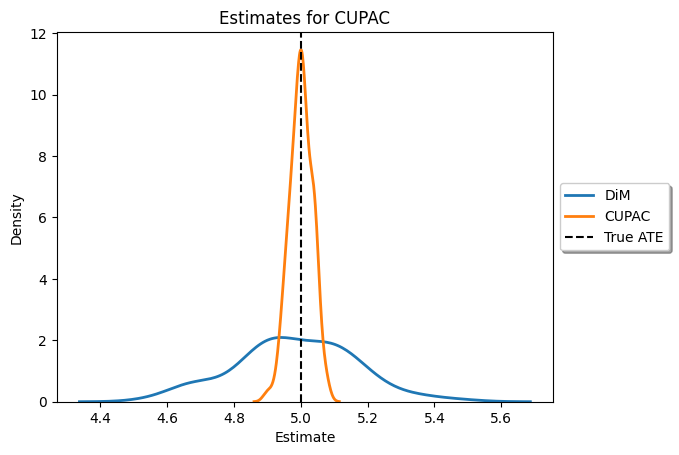

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Estimates for CUPAC'}, xlabel='Estimate', ylabel='Density'>)

In [25]:
evaluation_cupac.plot(plot_what='estimates')

### MLRATE

In [26]:
mlrate_params_map = {
    'MLRATE': {
        'covariate_columns': ['pre_metric'],
        'K_splits': 2,
        'model': ElasticNet,
        'model_init_config': {},
        'model_fit_config': {
        }
    }
}

In [27]:
mlrate_evaluation = VREvaluation(MLRATE)
mlrate_evaluation = mlrate_evaluation.run(data=simple_synthetic_df,
                                            treatment_column='treatment',
                                            target_column='exp_metric',
                                            method_params_map=mlrate_params_map,
                                            verbose=True,
                                            n_bootstrap=100,
                                            true_ate=5)

Running MLRATE...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 58.47it/s]


In [28]:
mlrate_evaluation.report()

,Method,Estimate,Estimate CI,Bias,Bias CI,p-value,p-value CI,Coverage Probability,Variance Reduction
0,MLRATE,5.022592,"(4.9759906971919206, 5.063654777320125)",0.022592,"(-0.024009302808079093, 0.06365477732012537)",0.0,"(0.0, 0.0)",0.83,0.98025


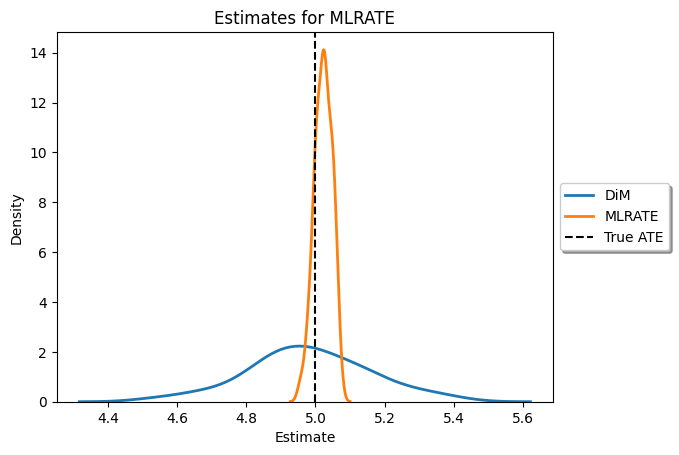

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Estimates for MLRATE'}, xlabel='Estimate', ylabel='Density'>)

In [29]:
mlrate_evaluation.plot(plot_what='estimates')

In [36]:
# # get training error
# mlrate_evaluation.estimators[0]._diag['g_k_scores']

In [37]:
# err = mlrate_evaluation.estimators[0]._diag['g_pred'] - mlrate_evaluation.estimators[0]._diag['target']
# mse = np.mean(err**2)

In [39]:
# # plot histogram of g_pred and the target
# plt.hist(mlrate_evaluation.estimators[0]._diag['g_pred'], bins=30, color='skyblue', edgecolor='black', alpha=0.5, label='g_pred')
# plt.hist(mlrate_evaluation.estimators[0]._diag['target'], bins=30, color='red', edgecolor='black', alpha=0.5, label='target')
# plt.legend()
# plt.show()


In [40]:
# plt.plot(mlrate_evaluation.estimators[0]._diag['g_pred'])
# plt.show()

In [41]:
mlrate_evaluation.bootstrap_samples[0]

array([8492, 2170, 4936, ..., 5420, 6330, 9709])

In [42]:
b_df = simple_synthetic_df.iloc[mlrate_evaluation.bootstrap_samples[0]].reset_index(drop=True)

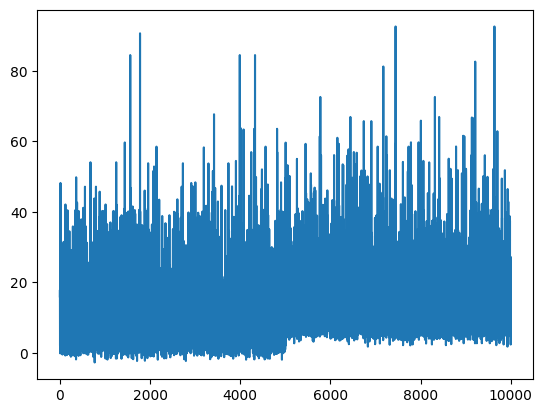

In [43]:
plt.plot(b_df['exp_metric'])
plt.show()

### Doubly Robust Estimator

In [44]:
dre_params_map = {
    'DoublyRobustEstimator': {
        'covariate_columns': ['pre_metric'],
        'model_regression': ExtraTreesRegressor
    }
}

In [45]:
dre_evaluation = VREvaluation(DoublyRobustEstimator)

In [46]:
dre_evaluation = dre_evaluation.run(data=simple_synthetic_df,
                                    treatment_column='treatment',
                                    target_column='exp_metric',
                                    method_params_map=dre_params_map,
                                    verbose=True,
                                    n_bootstrap=100,
                                    true_ate=5)


Running DoublyRobustEstimator...


100%|█████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


In [47]:
dre_evaluation.report()

,Method,Estimate,Estimate CI,Bias,Bias CI,p-value,p-value CI,Coverage Probability,Variance Reduction
0,DoublyRobustEstimator,5.027346,"(4.96688140607538, 5.0764011661990835)",0.027346,"(-0.03311859392462013, 0.07640116619908385)",None,None,0.8,0.982267


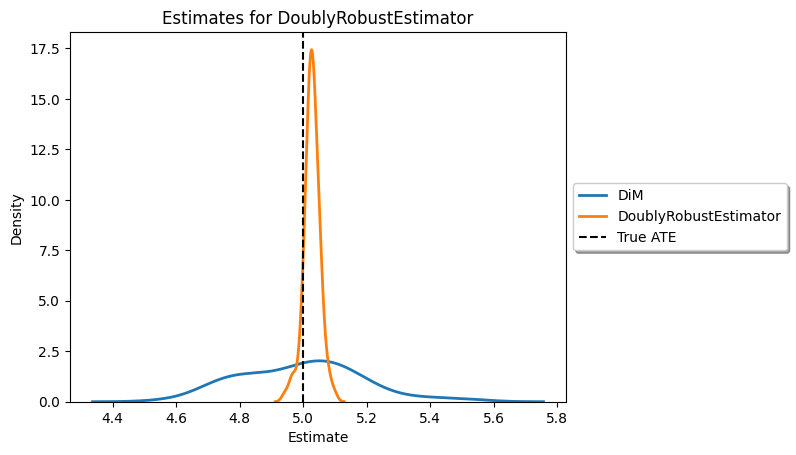

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Estimates for DoublyRobustEstimator'}, xlabel='Estimate', ylabel='Density'>)

In [48]:
dre_evaluation.plot(plot_what='estimates')

### Alt MLRATE

In [49]:
altmlrate = AltMLRATE()

In [50]:
altmlrate = altmlrate.fit(data=simple_synthetic_df,
                          treatment_column='treatment',
                          target_column='exp_metric',
                          covariate_columns=['pre_metric'],
                          K_splits=2)     

In [51]:
altmlrate.regression_results.params['treatment']

5.045404871067564

In [52]:
altmlrate_params_map = {
    'AltMLRATE': {
        'covariate_columns': ['pre_metric'],
        'K_splits': 2,
        'model': LGBMRegressor,
        'model_init_config': {},
        'model_fit_config': {
        }
    }
}

In [53]:
altmlrate_evaluation = VREvaluation(AltMLRATE)

In [54]:
altmlrate_evaluation = altmlrate_evaluation.run(data=simple_synthetic_df,
                                                treatment_column='treatment',
                                                target_column='exp_metric',
                                                method_params_map=altmlrate_params_map,
                                                verbose=True,
                                                n_bootstrap=100,
                                                true_ate=5)

Running AltMLRATE...


100%|█████████████████████████████████████████| 100/100 [00:55<00:00,  1.81it/s]


In [55]:
altmlrate_evaluation.report()

,Method,Estimate,Estimate CI,Bias,Bias CI,p-value,p-value CI,Coverage Probability,Variance Reduction
0,AltMLRATE,4.905037,"(4.830043188838198, 4.9801261018137515)",-0.094963,"(-0.1699568111618013, -0.019873898186248448)",0.0,"(0.0, 0.0)",0.17,0.970467


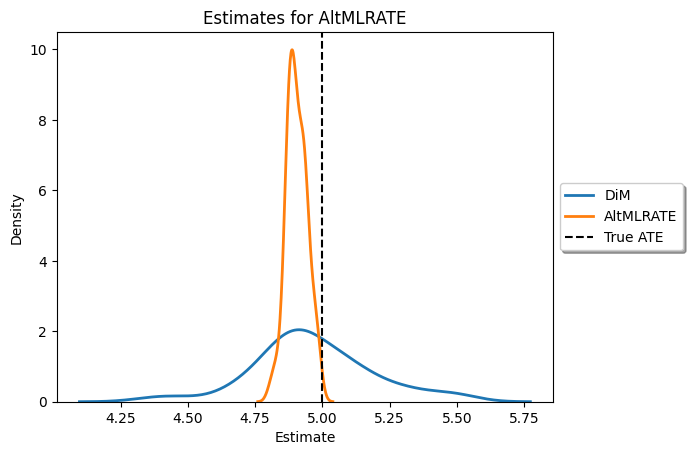

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Estimates for AltMLRATE'}, xlabel='Estimate', ylabel='Density'>)

In [56]:
altmlrate_evaluation.plot(plot_what='estimates')

In [57]:
baseline_params_map = {
    'DifferenceInMeans': {
    }
}

In [58]:
baseline_evaluation = VREvaluation(DifferenceInMeans)

In [59]:
baseline_evaluation = baseline_evaluation.run(data=simple_synthetic_df,
                                                treatment_column='treatment',
                                                target_column='exp_metric',
                                                method_params_map=baseline_params_map,
                                                verbose=True,
                                                n_bootstrap=100,
                                                true_ate=5)

Running DifferenceInMeans...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 422.86it/s]


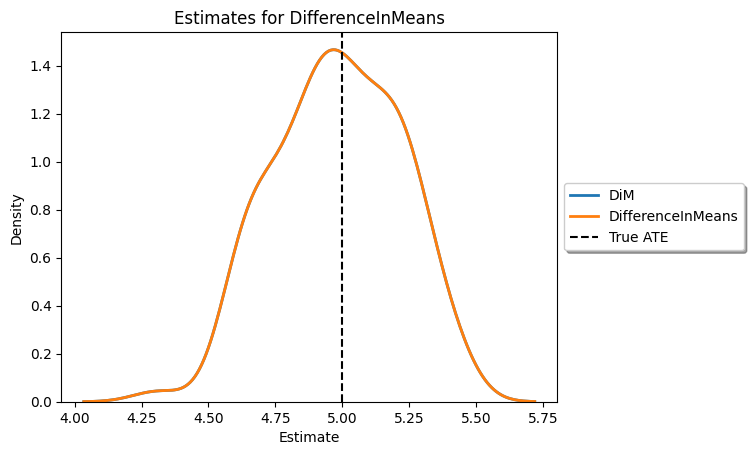

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Estimates for DifferenceInMeans'}, xlabel='Estimate', ylabel='Density'>)

In [60]:
baseline_evaluation.plot(plot_what='estimates')

In [61]:
def dgp(n=2000, p=10, linear=True, constant=True):
    """DGP from https://github.com/muratunalphd/Blog-Posts/blob/main/variance-reduction-methods/MLRATE.ipynb"""
        
    Xmat = np.random.multivariate_normal(np.zeros(p), np.eye(p), size=n).astype('float32')

    T = np.random.binomial(1, 0.5, n).astype('int8')

    col_list = ['X' + str(x) for x in range(1,(p+1))]

    df = pd.DataFrame(Xmat, columns = col_list)
    
    # functional form of the covariates
    if linear:
        B = 225 + 50*df['X1'] + 5*df['X2'] + 20*(df['X3']-0.5) + 10*df['X4'] + 5*df['X5']
    else:
        B = 225 + 50*df['X1'] + 5*np.sin(np.pi*df['X1']*df['X2'] ) + 10*(df['X3']-0.5)**2 + 10*df['X4']**2 + 5*df['X5']**3
    
    # constant ate or non-constant
    tau = 1.8 if constant else 5*df['X1'] + 5*np.log(1 + np.exp(df['X2']))
    
    # Y = (B + tau*T + np.random.normal(0,25,n)).astype('float32')
    Y = (B + tau*T + np.random.normal(0,25,n)).astype('float32')
        
    df['T'] = T
    df['Y'] = Y    
    return df

In [62]:
nonlinear_synthetic_df = dgp(n=2000, p=10, linear=False, constant=True)
linear_synthetic_df = dgp(n=2000, p=10, linear=True, constant=True)

In [63]:
altmlrate_params_map = {
    'AltMLRATE': {
        'covariate_columns': list(linear_synthetic_df.columns[2:]),
        'K_splits': 2,
        'model': None,
        'model_init_config': {},
        'model_fit_config': {
        }
    }
}

In [64]:
altmlrate_evaluation = VREvaluation(AltMLRATE)

In [65]:
altmlrate_evaluation = altmlrate_evaluation.run(data=linear_synthetic_df,
                                                treatment_column='T',
                                                target_column='Y',
                                                method_params_map=altmlrate_params_map,
                                                verbose=True,
                                                n_bootstrap=100,
                                                true_ate=5)

Running AltMLRATE...


100%|█████████████████████████████████████████| 100/100 [01:11<00:00,  1.39it/s]


In [66]:
altmlrate_evaluation.report()

,Method,Estimate,Estimate CI,Bias,Bias CI,p-value,p-value CI,Coverage Probability,Variance Reduction
0,AltMLRATE,0.087244,"(-0.09011336392849822, 0.2300633392067754)",-4.912756,"(-5.090113363928499, -4.769936660793225)",0.340525,"(0.016710705321446025, 0.9498528334454203)",0.0,0.998864


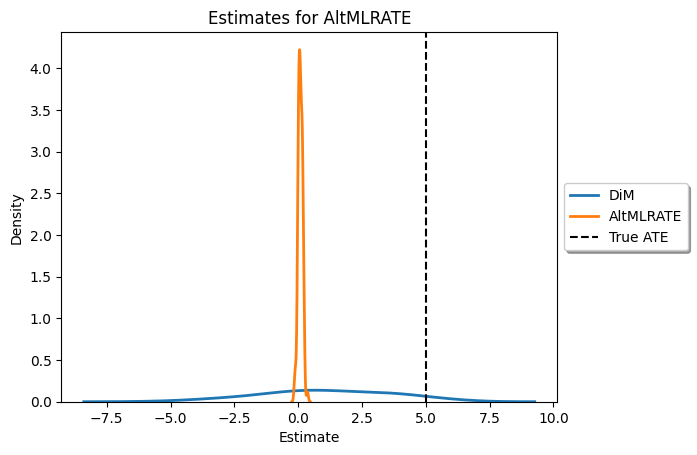

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Estimates for AltMLRATE'}, xlabel='Estimate', ylabel='Density'>)

In [67]:
altmlrate_evaluation.plot(plot_what='estimates')

In [68]:
altmlrate_evaluation.bootstrap_samples

array([[ 862, 1395,  413, ...,  903, 1895,   67],
       [ 133,  165,  177, ...,  784, 1221,  350],
       [1578,   32,  161, ..., 1668,  391, 1558],
       ...,
       [ 316, 1474,  619, ...,  553,  874, 1025],
       [1627,  797,  476, ...,  540, 1211,  146],
       [1925, 1621, 1423, ..., 1885,  464,  563]])

In [69]:
linear_synthetic_df.columns

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'T', 'Y'], dtype='object')

## More complicated synthetic data with linear effect

In [70]:
linear_synthetic_df
pre_exp_linear_synthetic_df = dgp(n=2000, p=10, linear=True, constant=True)
pre_exp_linear_synthetic_df = pre_exp_linear_synthetic_df.loc[pre_exp_linear_synthetic_df['T'] == 0]

### Eval All

In [71]:
method_params_map4 = {

    'DifferenceInMeans': {
    },
    
    'CUPED': {
        'covariate_column': linear_synthetic_df.columns.to_list()[0]
    },

    'MultivariateCUPED': {
        'covariate_columns': linear_synthetic_df.columns.to_list()[0:10]
    },

    'MultivariateRegression': {
        'covariate_columns': linear_synthetic_df.columns.to_list()[0:10]
    },

    'MultivariateRegressionAdjusted': {
        'covariate_columns': linear_synthetic_df.columns.to_list()[0:10]
    },

    'CUPAC': {
        'pre_experiment_data': pre_exp_linear_synthetic_df,
        'covariate_columns': pre_exp_linear_synthetic_df.columns.to_list()[0:10],
        'model': LGBMRegressor,
        'model_init_config': {},
        'model_fit_config': {}
    },

    'MLRATE': {
        'K_splits': 2,
        'covariate_columns': linear_synthetic_df.columns.to_list()[0:10],
        'model': ElasticNet,
        'model_init_config': {},
        'model_fit_config': {}
    },

    'DoublyRobustEstimator': {
        'covariate_columns': linear_synthetic_df.columns.to_list()[0:10],
        'model_regression': LGBMRegressor
        
    }

}

In [72]:
evaluator_all4 = VREvaluationAll([
                                  DifferenceInMeans, 
                                  CUPED, 
                                  MultivariateCUPED,
                                  MultivariateRegression, 
                                  MultivariateRegressionAdjusted, 
                                  CUPAC, 
                                  MLRATE
                                  , 
                                  DoublyRobustEstimator
                                  ])

In [73]:
evaluator_all4.run_all(data=linear_synthetic_df,
                       target_column='Y',
                       treatment_column='T',
                       method_params_map=method_params_map4,
                       verbose=True,
                       n_bootstrap=100,
                       true_ate=diff_in_means(linear_synthetic_df, 'T', 'Y'))
                       

Running DifferenceInMeans...


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1104.65it/s]


Running CUPED...


 24%|█████████▊                               | 24/100 [00:00<00:00, 239.01it/s]

[214.95224708  49.630438  ]
[214.87905228  47.97444535]
[216.9203576   48.52853569]
[216.96132676  48.56375147]
[216.83767729  49.17519517]
[214.94979507  49.7958028 ]
[217.02846235  48.92904393]
[215.52181812  48.18096255]
[217.111909    49.93683807]
[216.59039926  49.40510774]
[215.68185747  48.78943676]
[213.9696477   49.58995665]
[217.27918443  48.57382405]
[215.66350854  50.63356592]
[215.92479785  48.08279042]
[216.99674699  49.9266995 ]
[216.40607177  50.33347811]
[215.35151046  49.69808141]
[216.45295997  50.2810248 ]
[215.75741144  49.08634294]
[214.91883193  49.37200915]
[214.97275878  48.84151486]
[214.06658432  49.50659631]
[216.53135339  50.32695355]
[215.99452801  49.66835353]
[215.02998     48.90100535]
[215.16378692  49.11555521]
[214.62755454  49.77157494]
[213.81611387  49.03569904]
[216.15380234  49.42596673]
[214.93710795  49.04713587]
[216.50174554  49.04785153]
[214.81384665  49.74174125]
[216.50684767  49.07365667]
[215.60686781  49.06284746]
[215.63726848  49.85

 72%|█████████████████████████████▌           | 72/100 [00:00<00:00, 238.52it/s]

[214.9267557   50.18213612]
[215.28605958  50.61424864]
[215.42211304  49.71479628]
[216.30755513  48.44881334]
[216.30547865  48.5097036 ]
[217.24878838  49.53321224]
[215.06367122  51.14139735]
[214.75226608  48.1830796 ]
[215.56340448  48.73010699]
[213.59898297  49.54737287]
[215.33860188  49.64888673]
[217.20403549  48.49273132]
[214.84999605  50.78210549]
[215.19525802  49.87502205]
[214.17014853  50.61711493]
[214.41488503  48.90245918]
[216.04601067  49.67067901]
[214.74169236  49.56044457]
[216.03342032  49.09348102]
[216.48932158  50.98187686]
[216.19239533  49.39753873]
[214.42657771  50.19575687]
[215.18045087  49.61399283]
[215.59059173  49.54636048]
[215.84503718  49.27511778]
[214.70424259  48.948233  ]
[214.27336608  49.5143009 ]


 96%|███████████████████████████████████████▎ | 96/100 [00:00<00:00, 238.85it/s]

[216.00773297  49.80386181]
[215.8300559  48.283732 ]
[215.57588839  48.90712683]
[216.12500366  50.5514427 ]
[214.61151915  49.30667432]
[215.85051457  50.3525045 ]
[215.53602275  48.94833008]
[216.30387658  48.83369455]
[214.15156193  49.30717107]
[214.57967994  49.19490637]
[214.85350921  50.26463113]
[215.37037004  49.97882711]
[215.68179737  49.47704132]
[216.004329    48.82316376]
[216.00478713  49.74975148]
[215.62636761  49.41946005]
[216.48302302  49.21828467]
[214.90615214  49.21258462]
[214.38723374  49.84154946]
[215.80377904  48.7208114 ]
[215.41792627  51.42853133]


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 238.12it/s]


[216.34541104  48.4630632 ]
[215.36650179  50.3117397 ]
[216.14332102  49.25018943]
[214.87310652  49.9974981 ]
Running MultivariateCUPED...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 232.02it/s]


Running MultivariateRegression...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 153.70it/s]


Running MultivariateRegressionAdjusted...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 78.32it/s]


Running CUPAC...


  1%|▍                                          | 1/100 [00:00<00:10,  9.07it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[5.71382532 0.9844733 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[12.4235443   0.95054102]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, numb

  3%|█▎                                         | 3/100 [00:00<00:07, 12.84it/s]

[8.36087648 0.97582255]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669


  5%|██▏                                        | 5/100 [00:00<00:06, 14.10it/s]

[8.61588088 0.97069809]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[10.88719895  0.96455606]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[6.06868036 0.97931237]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in t

  7%|███                                        | 7/100 [00:00<00:06, 14.45it/s]

[12.37483274  0.95631107]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669


  9%|███▊                                       | 9/100 [00:00<00:06, 14.98it/s]

[10.72873838  0.96348842]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[10.40813331  0.96574821]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[8.50161033 0.97632366]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in

 11%|████▌                                     | 11/100 [00:00<00:05, 14.92it/s]

[9.12887125 0.96556453]


 13%|█████▍                                    | 13/100 [00:00<00:05, 15.49it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[3.28672534 0.98895781]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[11.00515359  0.96350297]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, numb

 17%|███████▏                                  | 17/100 [00:01<00:05, 15.65it/s]

[12.76967816  0.95178098]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[6.3277176  0.98396329]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[6.17033604 0.98146869]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in t

 21%|████████▊                                 | 21/100 [00:01<00:05, 15.74it/s]

[7.99800185 0.97561344]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[10.38897838  0.9623028 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[11.1294069  0.9597521]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in t

 25%|██████████▌                               | 25/100 [00:01<00:04, 15.52it/s]

[7.66644049 0.9710942 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[3.41745683 0.99746119]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[7.63781454 0.97482203]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the

 29%|████████████▏                             | 29/100 [00:01<00:04, 15.83it/s]

[10.07576143  0.96314222]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[7.33112886 0.97765952]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[13.08788044  0.94779435]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in

 31%|█████████████                             | 31/100 [00:02<00:04, 15.76it/s]

[12.12537151  0.94970624]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[8.68554291 0.97375021]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669


 33%|█████████████▊                            | 33/100 [00:02<00:07,  8.40it/s]

[6.14334211 0.97879699]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[9.33410551 0.9685384 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669


 35%|██████████████▋                           | 35/100 [00:03<00:10,  6.18it/s]

[6.38009043 0.98121121]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669


 38%|███████████████▉                          | 38/100 [00:03<00:08,  7.44it/s]

[2.25682458 0.9980191 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[5.59815483 0.98945733]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[8.43198315 0.96370596]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the

 42%|█████████████████▋                        | 42/100 [00:03<00:05, 10.41it/s]

[13.73883099  0.94686242]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[12.0927768   0.95897674]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[8.99736365 0.97146424]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in

 46%|███████████████████▎                      | 46/100 [00:03<00:04, 12.57it/s]

[8.67266693 0.97216819]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[6.22770701 0.98168308]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[8.53190888 0.97202702]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the

 50%|█████████████████████                     | 50/100 [00:04<00:03, 14.08it/s]

[11.42674696  0.95666297]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[3.35052697 0.99312889]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[6.69961717 0.98024892]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in t

 54%|██████████████████████▋                   | 54/100 [00:04<00:03, 15.25it/s]

[10.58624374  0.9659607 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[10.61739519  0.96446397]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[8.43649051 0.97652906]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in

 58%|████████████████████████▎                 | 58/100 [00:04<00:02, 15.96it/s]

[6.2811404  0.97954128]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[9.41581299 0.96385444]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[9.10780326 0.96390642]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the

 62%|██████████████████████████                | 62/100 [00:04<00:02, 15.36it/s]

[12.85168859  0.95338562]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[2.84017761 0.99393355]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[6.99846214 0.97828219]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in t

 66%|███████████████████████████▋              | 66/100 [00:05<00:02, 15.89it/s]

[10.31068706  0.95903867]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[7.38817846 0.97892309]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[9.21533105 0.96433691]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in t

 70%|█████████████████████████████▍            | 70/100 [00:05<00:01, 15.99it/s]

[5.20718725 0.98573788]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[9.83876963 0.96556001]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[5.8982608  0.98135658]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the

 74%|███████████████████████████████           | 74/100 [00:05<00:01, 16.20it/s]

[6.06897261 0.9779872 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[9.35207937 0.96858517]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[7.86516663 0.97320517]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the

 78%|████████████████████████████████▊         | 78/100 [00:05<00:01, 16.20it/s]

[6.17178854 0.98475283]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[11.08905666  0.96081449]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[11.2386628   0.96142604]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in

 82%|██████████████████████████████████▍       | 82/100 [00:06<00:01, 16.54it/s]

[6.09378541 0.97939623]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[7.77294055 0.97650808]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[9.65216957 0.96451793]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the

 86%|████████████████████████████████████      | 86/100 [00:06<00:00, 16.41it/s]

[10.69066897  0.95906025]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[11.27940939  0.95680863]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[5.69939975 0.98056352]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in

 90%|█████████████████████████████████████▊    | 90/100 [00:06<00:00, 16.59it/s]

[7.1020053  0.97678918]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[8.23162707 0.97147808]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[9.74931148 0.96411833]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the

 94%|███████████████████████████████████████▍  | 94/100 [00:06<00:00, 16.67it/s]

[8.16701852 0.97794272]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[12.2236408   0.95517086]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[9.52198583 0.9633625 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in t

 98%|█████████████████████████████████████████▏| 98/100 [00:07<00:00, 14.62it/s]

[8.04533932 0.9762244 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[4.19367215 0.98922198]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[13.22986502  0.95647975]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in t

100%|█████████████████████████████████████████| 100/100 [00:07<00:00, 13.70it/s]


[6.31009157 0.97908131]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 10
[LightGBM] [Info] Start training from score 213.471669
[6.72854503 0.9765678 ]
Running MLRATE...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 102.93it/s]


Running DoublyRobustEstimator...


  1%|▍                                          | 1/100 [00:00<00:17,  5.65it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.304919
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 219.835048
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

  2%|▊                                          | 2/100 [00:00<00:17,  5.68it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.229796
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 218.203937
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

  4%|█▋                                         | 4/100 [00:00<00:23,  4.03it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 219.744784
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 220.423907
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

  5%|██▏                                        | 5/100 [00:01<00:22,  4.19it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 220.598962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.531442
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

  7%|███                                        | 7/100 [00:01<00:19,  4.87it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 218.317082
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 219.645910
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

  8%|███▍                                       | 8/100 [00:01<00:18,  4.99it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.064459
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 220.428545
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 10%|████▏                                     | 10/100 [00:02<00:17,  5.23it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 218.635209
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 220.821527
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 11%|████▌                                     | 11/100 [00:02<00:16,  5.37it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 219.213078
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 215.519515
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 13%|█████▍                                    | 13/100 [00:02<00:15,  5.53it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.963624
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2547
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 223.062943
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 14%|█████▉                                    | 14/100 [00:02<00:15,  5.56it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 220.498988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 218.857027
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 16%|██████▋                                   | 16/100 [00:03<00:14,  5.63it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 218.223557
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2546
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 219.494321
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 17%|███████▏                                  | 17/100 [00:03<00:14,  5.55it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 220.207368
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 215.348025
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 19%|███████▉                                  | 19/100 [00:03<00:14,  5.41it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2546
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 216.796557
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.010614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 20%|████████▍                                 | 20/100 [00:03<00:14,  5.44it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 218.174244
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 218.885938
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 22%|█████████▏                                | 22/100 [00:04<00:14,  5.49it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.541121
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 216.610657
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 23%|█████████▋                                | 23/100 [00:04<00:13,  5.56it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 215.587179
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.725093


 24%|██████████                                | 24/100 [00:04<00:17,  4.34it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.721670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 214.207304


 25%|██████████▌                               | 25/100 [00:05<00:17,  4.38it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 219.045581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 218.260616
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 27%|███████████▎                              | 27/100 [00:05<00:14,  4.96it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 216.234887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 218.571387
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 28%|███████████▊                              | 28/100 [00:05<00:13,  5.16it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 219.106145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 215.433529
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 30%|████████████▌                             | 30/100 [00:05<00:13,  5.37it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 219.115169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 216.805884
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 31%|█████████████                             | 31/100 [00:06<00:12,  5.47it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 221.096298
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.448978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 33%|█████████████▊                            | 33/100 [00:06<00:12,  5.57it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.918739
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.837050
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 34%|██████████████▎                           | 34/100 [00:06<00:12,  5.22it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 216.935628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2547
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 218.977450
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 36%|███████████████                           | 36/100 [00:07<00:11,  5.41it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 215.031852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2547
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.527714
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 37%|███████████████▌                          | 37/100 [00:07<00:11,  5.50it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.707805
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.070100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 39%|████████████████▍                         | 39/100 [00:07<00:11,  5.51it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2547
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 215.951562
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 218.792931
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 40%|████████████████▊                         | 40/100 [00:07<00:10,  5.48it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 219.662437
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.891229
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 42%|█████████████████▋                        | 42/100 [00:08<00:10,  5.45it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 221.443620
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2547
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 216.861816
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 43%|██████████████████                        | 43/100 [00:08<00:10,  5.48it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 219.047547
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 215.692538
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 45%|██████████████████▉                       | 45/100 [00:08<00:09,  5.55it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.140784
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 218.555180
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 46%|███████████████████▎                      | 46/100 [00:08<00:09,  5.59it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 219.513338
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 215.227704
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 48%|████████████████████▏                     | 48/100 [00:09<00:09,  5.65it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.123114
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 219.214862
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 49%|████████████████████▌                     | 49/100 [00:09<00:08,  5.67it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 219.200466
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 220.920237
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 51%|█████████████████████▍                    | 51/100 [00:09<00:08,  5.62it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 218.581428
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.747375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 52%|█████████████████████▊                    | 52/100 [00:10<00:11,  4.12it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 220.794620
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 220.333963


 53%|██████████████████████▎                   | 53/100 [00:10<00:16,  2.92it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 216.119476


 54%|██████████████████████▋                   | 54/100 [00:11<00:16,  2.84it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 220.750513
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.506394
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2546
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 56%|███████████████████████▌                  | 56/100 [00:11<00:11,  3.77it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 215.487454
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 216.083392
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 57%|███████████████████████▉                  | 57/100 [00:11<00:10,  4.17it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.754275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 215.579277
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 59%|████████████████████████▊                 | 59/100 [00:11<00:08,  4.78it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.648047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 215.089538
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2547
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 60%|█████████████████████████▏                | 60/100 [00:12<00:07,  5.06it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 220.162435
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.640513
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 62%|██████████████████████████                | 62/100 [00:12<00:07,  5.25it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 212.984900
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.134873
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 63%|██████████████████████████▍               | 63/100 [00:12<00:06,  5.30it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 216.151078
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 220.420792
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 65%|███████████████████████████▎              | 65/100 [00:13<00:06,  5.45it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 219.486368
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 218.910323
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 66%|███████████████████████████▋              | 66/100 [00:13<00:06,  5.51it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.425498
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 215.313031
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 68%|████████████████████████████▌             | 68/100 [00:13<00:05,  5.64it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.965298
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 221.788135
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 69%|████████████████████████████▉             | 69/100 [00:13<00:05,  5.59it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 218.736270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 214.615126
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 71%|█████████████████████████████▊            | 71/100 [00:14<00:05,  5.48it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 219.189172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 216.125844
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 72%|██████████████████████████████▏           | 72/100 [00:14<00:05,  5.46it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 219.108968
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 218.842304
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 74%|███████████████████████████████           | 74/100 [00:14<00:04,  5.53it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 219.962834
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 215.472618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 75%|███████████████████████████████▌          | 75/100 [00:14<00:04,  5.60it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 216.338983
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 215.442630
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 77%|████████████████████████████████▎         | 77/100 [00:15<00:04,  5.54it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.592289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 219.180537
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 78%|████████████████████████████████▊         | 78/100 [00:15<00:03,  5.55it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.224193
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 220.262508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 80%|█████████████████████████████████▌        | 80/100 [00:15<00:03,  5.55it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 216.325092
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 213.479389
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 81%|██████████████████████████████████        | 81/100 [00:15<00:03,  5.51it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 219.028487
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 215.828406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 83%|██████████████████████████████████▊       | 83/100 [00:16<00:03,  5.56it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 221.440373
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.946773
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 84%|███████████████████████████████████▎      | 84/100 [00:16<00:02,  5.62it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2547
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 216.615864
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 216.792076
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 86%|████████████████████████████████████      | 86/100 [00:16<00:02,  5.30it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.078308
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 214.100936
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 87%|████████████████████████████████████▌     | 87/100 [00:17<00:02,  5.24it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 218.606842
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2547
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.539187
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 89%|█████████████████████████████████████▍    | 89/100 [00:17<00:02,  5.45it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 218.412667
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.521997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2546
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 90%|█████████████████████████████████████▊    | 90/100 [00:17<00:01,  5.54it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 218.856571
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 214.929896
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 92%|██████████████████████████████████████▋   | 92/100 [00:17<00:01,  5.57it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2547
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 219.261654
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2547
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 220.560399
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2546
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 93%|███████████████████████████████████████   | 93/100 [00:18<00:01,  5.58it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 214.536714
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.568276
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 95%|███████████████████████████████████████▉  | 95/100 [00:18<00:00,  5.54it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.013384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 220.081471
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 96%|████████████████████████████████████████▎ | 96/100 [00:18<00:00,  5.54it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.696243
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2547
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 218.531990
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 98%|█████████████████████████████████████████▏| 98/100 [00:18<00:00,  5.61it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 220.062893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 217.508095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

 99%|█████████████████████████████████████████▌| 99/100 [00:19<00:00,  5.65it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 216.315406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score 218.080842
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start tr

100%|█████████████████████████████████████████| 100/100 [00:19<00:00,  5.17it/s]

Done!


In [74]:
evaluator_all4.report()

,Method,Estimate,Estimate CI,Bias,Bias CI,p-value,p-value CI,Coverage Probability,Variance Reduction
0,DifferenceInMeans,1.827953,"(-4.247970983562693, 7.121047804478801)",0.260936,"(-5.814987585125193, 5.554031202916301)",0.390964,"(0.008372512798932209, 0.9636015278061764)",0.00,0.000000
1,CUPED,0.876658,"(-2.148664453190579, 3.3788118067268287)",-0.690359,"(-3.715681054753079, 1.8117952051643285)",0.425815,"(0.028683376219908237, 0.9434604584078091)",0.94,0.657031
2,MultivariateCUPED,0.797190,"(-1.2581362294295595, 2.92622449602615)",-0.769827,"(-2.8251528309920597, 1.35920789446365)",0.42546,"(0.009421799589276341, 0.9323743731554767)",0.91,0.832363
3,MultivariateRegression,0.807186,"(-1.2677475160317069, 2.9704756066099596)",-0.759830,"(-2.8347641175942067, 1.4034590050474596)",0.424319,"(0.009271927765990427, 0.9321150551922817)",0.91,0.828423
4,MultivariateRegressionAdjusted,0.814424,"(-1.2731731465284335, 2.9884566014573792)",-0.752593,"(-2.8401897480909333, 1.421439999894879)",0.422242,"(0.00870655171569346, 0.9334207455362962)",0.91,0.827893
5,CUPAC,1.103295,"(-1.2747594518301248, 3.4621142092990045)",-0.463722,"(-2.841776053392625, 1.8950976077365047)",0.373002,"(0.005510081558294086, 0.914037218322878)",0.92,0.762862
6,MLRATE,0.812556,"(-1.3207609222111252, 2.926788658777747)",-0.754460,"(-2.887777523773625, 1.359772057215247)",0.4303,"(0.010058467172921769, 0.9556663540742095)",0.91,0.822752
7,DoublyRobustEstimator,0.467723,"(-1.194061635076553, 2.676967546287553)",-1.099294,"(-2.761078236639053, 1.1099509447250528)",None,None,0.77,0.868637


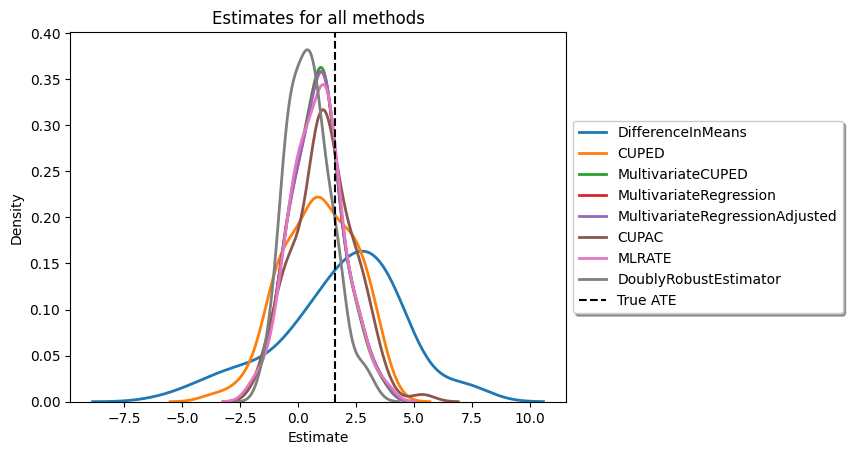

<Axes: title={'center': 'Estimates for all methods'}, xlabel='Estimate', ylabel='Density'>

In [75]:
evaluator_all4.plot(plot_what='estimates')

In [77]:
# evaluator_all4.evaluations['MLRATE'].estimators[10]._diag['g_k_scores']

In [78]:
# Y_0_mean = linear_synthetic_df.loc[linear_synthetic_df['T']==0]['Y'].mean()
# Y_1_mean = linear_synthetic_df.loc[linear_synthetic_df['T']==1]['Y'].mean()

# Y_1_mean - Y_0_mean

## More complicated synthetic data with nonlinear effect

In [79]:
nonlinear_synthetic_df
pre_exp_nonlinear_synthetic_df = dgp(n=2000, p=10, linear=False, constant=True)
pre_exp_nonlinear_synthetic_df = pre_exp_nonlinear_synthetic_df.loc[pre_exp_nonlinear_synthetic_df['T'] == 0]

### Eval All

In [80]:
method_params_map5 = {

    'DifferenceInMeans': {
    },
    
    'CUPED': {
        'covariate_column': nonlinear_synthetic_df.columns.to_list()[4]
    },

    'MultivariateCUPED': {
        'covariate_columns': nonlinear_synthetic_df.columns.to_list()[4:10] 
    },

    'MultivariateRegression': {
        'covariate_columns': nonlinear_synthetic_df.columns.to_list()[4:10]
    },

    'MultivariateRegressionAdjusted': {
        'covariate_columns': nonlinear_synthetic_df.columns.to_list()[4:10]
    },

    'CUPAC': {
        'pre_experiment_data': pre_exp_nonlinear_synthetic_df,
        'covariate_columns': pre_exp_nonlinear_synthetic_df.columns.to_list()[4:10],
        'model': LGBMRegressor,
        'model_init_config': {},
        'model_fit_config': {}
    },

    'MLRATE': {
        'K_splits': 2,
        'covariate_columns': nonlinear_synthetic_df.columns.to_list()[4:10],
        'model': LGBMRegressor,
        'model_init_config': {},
        'model_fit_config': {}
    },

    'DoublyRobustEstimator': {
        'covariate_columns': nonlinear_synthetic_df.columns.to_list()[4:10],
        'model_regression': LGBMRegressor

    }

}

In [81]:
evaluator_all5 = VREvaluationAll([DifferenceInMeans, 
                            CUPED, 
                            MultivariateCUPED,
                            MultivariateRegression, 
                            MultivariateRegressionAdjusted, 
                            CUPAC, 
                            MLRATE, 
                            DoublyRobustEstimator])

In [82]:
evaluator_all5.run_all(data=nonlinear_synthetic_df,
                       target_column='Y',
                       treatment_column='T',
                       method_params_map=method_params_map5,
                       verbose=True,
                       n_bootstrap=100,
                       true_ate=diff_in_means(nonlinear_synthetic_df, 'T', 'Y'))
                       

Running DifferenceInMeans...


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1082.69it/s]


Running CUPED...


 24%|█████████▊                               | 24/100 [00:00<00:00, 234.97it/s]

[251.27592081  16.71571021]
[249.1916149   17.99803551]
[247.73394282  13.81806927]
[246.33302738  12.24769081]
[250.34003923  15.92794744]
[247.16834069  16.49591661]
[252.2708787  15.0900676]
[249.14758131  17.77587445]
[250.85982617  18.21365925]
[250.13903015  17.59633739]
[249.94646208  17.623277  ]
[249.58489882  16.39472345]
[250.45283465  12.15280901]
[248.92139241  14.23772452]
[248.55494609  14.80569108]
[251.67217963  14.68389597]
[248.13364843  15.50289167]
[248.87964378  17.85680785]
[253.27287117  17.53395753]
[250.16363226  18.08926897]
[251.83926191  17.26663478]
[251.5258763   17.26136659]
[248.19742481  18.35866288]
[248.48747114  17.236467  ]
[250.5457709   15.34729034]
[249.28911303  16.44597762]
[252.79456331  16.55751753]
[250.47223399  16.15087014]
[252.28514235  15.57629117]
[250.6713732   18.16149111]
[251.56433538  16.38219137]
[249.23948934  16.89708828]
[250.19328539  17.4468327 ]
[250.61762229  17.00146577]
[249.13916867  14.97845011]
[251.04122426  16.1290

 48%|███████████████████▋                     | 48/100 [00:00<00:00, 231.05it/s]

[252.8861569   16.82980316]
[250.00342757  14.56089139]
[252.09726423  18.23085997]
[253.52198114  17.45750788]
[251.51517407  15.05027271]
[250.46007952  14.95188811]
[248.44879426  17.25504138]
[250.2324377   18.55151215]
[247.3555947   15.40392831]
[250.61577514  16.31382736]
[250.4495984  15.5063897]
[248.74706852  17.49027851]
[249.90057875  17.97561679]
[251.86788442  17.5368308 ]
[252.71671415  19.77127448]
[251.71542694  17.48521053]
[249.71530233  15.72151257]
[251.579206   17.9033472]
[249.13307081  18.92549685]
[250.93201344  17.67368788]
[252.05155288  16.60022551]
[251.83255717  13.70748686]
[250.4012005   16.31804999]
[250.45631135  14.52906533]
[250.7499376  17.0010236]
[248.51720609  19.05487398]


 73%|█████████████████████████████▉           | 73/100 [00:00<00:00, 234.97it/s]

[251.30152164  15.5912584 ]
[251.56474206  17.52870622]
[252.45382083  17.30891559]
[251.43463799  15.35417859]
[251.03315164  14.65467565]
[250.13925849  15.30202765]
[249.01217548  17.00122183]
[249.92697035  16.56954614]
[251.2727086   17.56761752]
[249.57059216  18.49407141]
[250.1309162   17.34972785]
[250.25217659  16.87468625]
[248.64173098  17.26855139]
[251.05478392  16.58654321]
[250.31864126  16.75849107]
[251.99055003  15.55252894]
[249.89591067  15.30158308]
[250.54364064  17.60456112]
[251.40095881  15.61929065]
[251.32618756  17.85743041]
[251.83856364  14.2717979 ]
[250.40762019  16.79940672]


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 233.84it/s]


[247.99766576  17.25870515]
[251.65596987  17.68659309]
[247.91544608  16.76873134]
[252.41990116  16.57261073]
[250.54045131  17.96979074]
Running MultivariateCUPED...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 227.96it/s]


Running MultivariateRegression...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 182.83it/s]


Running MultivariateRegressionAdjusted...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 109.63it/s]


Running CUPAC...


  2%|▊                                          | 2/100 [00:00<00:07, 13.76it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[183.17997351   0.27315414]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[2.11135174e+02 1.57785155e-01]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993,

  6%|██▌                                        | 6/100 [00:00<00:06, 14.55it/s]

[193.33319925   0.21942433]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[193.66568587   0.21091116]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[2.01272702e+02 1.99582912e-01]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data p

  8%|███▍                                       | 8/100 [00:00<00:06, 14.78it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[2.08984789e+02 1.74417328e-01]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[173.01778467   0.30714926]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993,

 12%|█████                                     | 12/100 [00:00<00:05, 14.88it/s]

[180.17711883   0.28074787]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[178.43475366   0.28635821]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[197.62251011   0.20996216]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data point

 14%|█████▉                                    | 14/100 [00:01<00:08, 10.60it/s]

[197.95412953   0.21067035]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[197.56402932   0.20769569]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[2.03181305e+02 1.81188914e-01]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data p

 18%|███████▌                                  | 18/100 [00:01<00:06, 12.32it/s]

[198.54125466   0.21432683]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[190.73229265   0.23133348]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[184.69105342   0.25799023]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data point

 22%|█████████▏                                | 22/100 [00:01<00:05, 13.76it/s]

[192.83320443   0.2422312 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[185.01537916   0.25982382]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[188.62700355   0.25343148]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data point

 24%|██████████                                | 24/100 [00:01<00:05, 14.10it/s]

[176.46673172   0.28821578]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[178.96742404   0.28001893]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[193.74536867   0.2297954 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data point

 28%|███████████▊                              | 28/100 [00:02<00:06, 11.63it/s]

[176.3664207    0.29268229]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[201.22840583   0.20762396]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[191.6759762    0.23608825]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data point

 32%|█████████████▍                            | 32/100 [00:02<00:05, 12.94it/s]

[2.01330542e+02 1.98229267e-01]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[178.44368462   0.29283158]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[199.3320056    0.20362549]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data p

 36%|███████████████                           | 36/100 [00:02<00:04, 14.03it/s]

[172.80736902   0.31513313]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[195.73361136   0.22054904]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[198.42809448   0.20419138]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data point

 38%|███████████████▉                          | 38/100 [00:02<00:04, 14.14it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[186.67478465   0.25366823]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[198.87060644   0.20218423]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, num

 40%|████████████████▊                         | 40/100 [00:03<00:04, 14.26it/s]

[181.84552016   0.28864477]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[196.63799955   0.22289775]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[185.9404354    0.25796016]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data point

 44%|██████████████████▍                       | 44/100 [00:03<00:03, 14.69it/s]

[188.24863094   0.25008748]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[193.00691959   0.23197503]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[2.04024631e+02 1.88211643e-01]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data p

 48%|████████████████████▏                     | 48/100 [00:03<00:03, 14.92it/s]

[173.9938574    0.31341416]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[193.00178374   0.23105343]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[171.03533463   0.33012746]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data point

 50%|█████████████████████                     | 50/100 [00:03<00:03, 14.54it/s]

[199.70115337   0.20295471]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[2.03408419e+02 1.97667765e-01]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[189.84796389   0.25586366]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data p

 54%|██████████████████████▋                   | 54/100 [00:03<00:03, 14.87it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[176.91785159   0.29525114]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[1.99222896e+02 1.99012492e-01]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993,

 58%|████████████████████████▎                 | 58/100 [00:04<00:02, 15.17it/s]

[188.01548086   0.23815369]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[186.89605189   0.25760085]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[189.22264681   0.24839458]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data point

 62%|██████████████████████████                | 62/100 [00:04<00:02, 15.77it/s]

[183.69094509   0.26521602]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[178.82009644   0.29108699]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[181.12123846   0.28886744]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data point

 64%|██████████████████████████▉               | 64/100 [00:04<00:02, 15.11it/s]

[168.85013119   0.33232552]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[2.04556714e+02 1.81592982e-01]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[176.82131752   0.30294995]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Lig

 68%|████████████████████████████▌             | 68/100 [00:04<00:02, 14.75it/s]

[183.85432558   0.26422418]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[176.00518875   0.30253408]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[184.17533762   0.27107709]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data point

 70%|█████████████████████████████▍            | 70/100 [00:05<00:02, 14.30it/s]

[195.66743743   0.22422727]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[184.94604101   0.26389913]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[192.95334525   0.23245931]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data point

 74%|███████████████████████████████           | 74/100 [00:05<00:02, 10.71it/s]

[180.3211227   0.2814659]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[176.74556665   0.29066238]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[193.10046727   0.23496484]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points 

 78%|████████████████████████████████▊         | 78/100 [00:05<00:01, 11.79it/s]

[200.60597575   0.20808854]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[195.91506353   0.22088699]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[196.88580484   0.21868521]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data point

 80%|█████████████████████████████████▌        | 80/100 [00:06<00:01, 12.67it/s]

[192.11914205   0.23485081]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[186.16255452   0.25167346]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[187.15118936   0.25141977]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data point

 84%|███████████████████████████████████▎      | 84/100 [00:06<00:01, 13.28it/s]

[192.23083817   0.23671077]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[173.92481432   0.3037149 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[182.69716579   0.27295622]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data point

 86%|████████████████████████████████████      | 86/100 [00:06<00:01, 13.50it/s]

[186.28928763   0.25897049]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[184.84273614   0.25756883]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[187.03240437   0.260005  ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data point

 90%|█████████████████████████████████████▊    | 90/100 [00:06<00:00, 14.23it/s]

[188.25254764   0.25039682]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[194.52467903   0.23129162]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[2.13247710e+02 1.48082457e-01]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data p

 92%|██████████████████████████████████████▋   | 92/100 [00:06<00:00, 14.60it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[186.15588077   0.26218573]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[167.56110219   0.3350155 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, num

 94%|███████████████████████████████████████▍  | 94/100 [00:07<00:00, 12.29it/s]

[184.54288613   0.2714368 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[190.87886104   0.24032837]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425


 96%|████████████████████████████████████████▎ | 96/100 [00:07<00:00,  7.52it/s]

[184.82254606   0.2548151 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425


 98%|█████████████████████████████████████████▏| 98/100 [00:08<00:00,  6.19it/s]

[193.87787171   0.23228174]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[181.2466283    0.26788864]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 12.17it/s]


[193.53522719   0.23498576]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 6
[LightGBM] [Info] Start training from score 249.376425
[184.41121486   0.26901121]
Running MLRATE...


  1%|▍                                          | 1/100 [00:00<00:12,  8.08it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 253.414302
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 250.383542
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

  2%|▊                                          | 2/100 [00:00<00:11,  8.44it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 247.822089
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1526
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 248.985958


  3%|█▎                                         | 3/100 [00:00<00:11,  8.55it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 244.707799
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 248.635100


  4%|█▋                                         | 4/100 [00:00<00:11,  8.06it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 253.476389


  5%|██▏                                        | 5/100 [00:00<00:12,  7.84it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 249.443490
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 249.018996
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

  6%|██▌                                        | 6/100 [00:00<00:12,  7.76it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1526
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 253.699860


  7%|███                                        | 7/100 [00:00<00:11,  8.21it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 251.897850
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 250.193284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

  8%|███▍                                       | 8/100 [00:00<00:11,  8.13it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 252.538564


  9%|███▊                                       | 9/100 [00:01<00:11,  7.93it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 250.116922
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 248.859402
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 11%|████▌                                     | 11/100 [00:01<00:11,  7.92it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 249.321618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 251.514053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 13%|█████▍                                    | 13/100 [00:01<00:10,  8.00it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 250.138765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 251.556622
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 15%|██████▎                                   | 15/100 [00:01<00:10,  8.21it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 249.268057
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 247.991076
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 16%|██████▋                                   | 16/100 [00:02<00:11,  7.61it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 249.424875
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 248.388184


 17%|███████▏                                  | 17/100 [00:02<00:10,  7.65it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 249.366109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 250.004999


 18%|███████▌                                  | 18/100 [00:02<00:11,  7.40it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 256.059110


 19%|███████▉                                  | 19/100 [00:02<00:11,  7.13it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 251.934886
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 251.005431
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 21%|████████▊                                 | 21/100 [00:02<00:10,  7.62it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 253.144601
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 251.393055
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 23%|█████████▋                                | 23/100 [00:02<00:09,  7.90it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 247.519324
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 250.991717
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 25%|██████████▌                               | 25/100 [00:03<00:10,  7.42it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 250.525588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 251.225371
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1526
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 27%|███████████▎                              | 27/100 [00:03<00:09,  7.74it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 248.696597
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 254.342866
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 29%|████████████▏                             | 29/100 [00:03<00:09,  7.54it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 251.696061
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 251.826439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 30%|████████████▌                             | 30/100 [00:03<00:10,  6.53it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 251.711447
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 250.652394
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 31%|█████████████                             | 31/100 [00:04<00:10,  6.71it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 251.116943
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 248.462399
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 33%|█████████████▊                            | 33/100 [00:04<00:09,  6.74it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 253.255787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 250.342989
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 34%|██████████████▎                           | 34/100 [00:04<00:09,  6.84it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 251.733716
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 248.422569
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 36%|███████████████                           | 36/100 [00:04<00:09,  6.93it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 251.687446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1525
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 252.560876
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 37%|███████████████▌                          | 37/100 [00:04<00:09,  6.90it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 250.511595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 249.625268
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 38%|███████████████▉                          | 38/100 [00:05<00:09,  6.86it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 253.430149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 255.337573


 39%|████████████████▍                         | 39/100 [00:05<00:10,  5.75it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 251.911058
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 253.329826


 40%|████████████████▊                         | 40/100 [00:05<00:14,  4.27it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1526
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 249.410318


 41%|█████████████████▏                        | 41/100 [00:06<00:16,  3.53it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 251.678184
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 249.308979


 42%|█████████████████▋                        | 42/100 [00:06<00:16,  3.42it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 253.612803
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 252.256773


 43%|██████████████████                        | 43/100 [00:06<00:17,  3.29it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 250.054632
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 249.695590


 44%|██████████████████▍                       | 44/100 [00:07<00:18,  3.06it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 252.652050
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 251.006532


 46%|███████████████████▎                      | 46/100 [00:07<00:13,  4.08it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 253.292692
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 254.866659
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 48%|████████████████████▏                     | 48/100 [00:07<00:09,  5.23it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 249.949296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 255.207456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 49%|████████████████████▌                     | 49/100 [00:07<00:08,  5.91it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 249.864489
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 251.545593
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 51%|█████████████████████▍                    | 51/100 [00:08<00:07,  6.71it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 255.574856
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 253.136528
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 53%|██████████████████████▎                   | 53/100 [00:08<00:06,  6.78it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 249.560903
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 252.400404
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 55%|███████████████████████                   | 55/100 [00:08<00:06,  6.84it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 250.747393
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 252.199140
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set

 57%|███████████████████████▉                  | 57/100 [00:09<00:05,  7.32it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 251.676025
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 251.770541
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 59%|████████████████████████▊                 | 59/100 [00:09<00:05,  7.75it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 251.476264
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 249.308652
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 61%|█████████████████████████▌                | 61/100 [00:09<00:04,  8.04it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 251.404176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 253.040656
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 63%|██████████████████████████▍               | 63/100 [00:09<00:04,  7.77it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 253.648168
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 251.408860
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 65%|███████████████████████████▎              | 65/100 [00:10<00:04,  7.58it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 251.996624
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 253.490994
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 67%|████████████████████████████▏             | 67/100 [00:10<00:04,  7.62it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 248.614714
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 252.844529
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 69%|████████████████████████████▉             | 69/100 [00:10<00:03,  8.17it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 253.924984
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 252.786530
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 70%|█████████████████████████████▍            | 70/100 [00:10<00:03,  7.98it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 250.574612
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 252.575683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 72%|██████████████████████████████▏           | 72/100 [00:10<00:03,  7.75it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 250.018159
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 251.952686
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 74%|███████████████████████████████           | 74/100 [00:11<00:03,  7.39it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 253.721157
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 250.591315
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 76%|███████████████████████████████▉          | 76/100 [00:11<00:02,  8.04it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 251.060751
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 254.915954
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 78%|████████████████████████████████▊         | 78/100 [00:11<00:02,  8.55it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 251.489261
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1525
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 252.418198
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 80%|█████████████████████████████████▌        | 80/100 [00:11<00:02,  8.07it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 250.206874
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 248.750280
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 82%|██████████████████████████████████▍       | 82/100 [00:12<00:02,  7.01it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 252.854343
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 250.063479
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 84%|███████████████████████████████████▎      | 84/100 [00:12<00:02,  7.63it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 251.200215
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 251.151365
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 86%|████████████████████████████████████      | 86/100 [00:12<00:01,  7.91it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1525
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 250.991443
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 248.568781
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 88%|████████████████████████████████████▉     | 88/100 [00:13<00:01,  7.74it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 251.345209
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 250.501800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 90%|█████████████████████████████████████▊    | 90/100 [00:13<00:01,  8.04it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 249.523698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 251.334825
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 92%|██████████████████████████████████████▋   | 92/100 [00:13<00:01,  6.74it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 250.586561
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 253.832662
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 94%|███████████████████████████████████████▍  | 94/100 [00:13<00:00,  7.45it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 251.771387
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 253.382127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 96%|████████████████████████████████████████▎ | 96/100 [00:14<00:00,  7.53it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 252.600431
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 250.777993
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 98%|█████████████████████████████████████████▏| 98/100 [00:14<00:00,  7.91it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 253.884844
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 248.676797
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

 99%|█████████████████████████████████████████▌| 99/100 [00:14<00:00,  7.52it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 251.214707
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start training from score 250.445570
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 6
[LightGBM] [Info] Start train

100%|█████████████████████████████████████████| 100/100 [00:14<00:00,  6.85it/s]


Running DoublyRobustEstimator...


  0%|                                                   | 0/100 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 250.821521
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 252.976323


  1%|▍                                          | 1/100 [00:00<00:45,  2.19it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1526
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 248.699071
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 253.077220


  2%|▊                                          | 2/100 [00:01<00:50,  1.95it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 247.913545


  3%|█▎                                         | 3/100 [00:01<00:42,  2.29it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 248.894503
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 247.356847
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

  5%|██▏                                        | 5/100 [00:01<00:25,  3.76it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 250.026437
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 252.893443
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

  6%|██▌                                        | 6/100 [00:01<00:21,  4.33it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 247.616789
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 251.624363
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

  8%|███▍                                       | 8/100 [00:02<00:17,  5.23it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 249.943241
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 250.893324
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

  9%|███▊                                       | 9/100 [00:02<00:16,  5.47it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 250.646106
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 252.428764
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 11%|████▌                                     | 11/100 [00:02<00:15,  5.85it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 251.280918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 249.554753
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 12%|█████                                     | 12/100 [00:02<00:14,  5.89it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 251.194318
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 252.547776
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 14%|█████▉                                    | 14/100 [00:03<00:14,  5.80it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 251.739406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 247.754795
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 15%|██████▎                                   | 15/100 [00:03<00:15,  5.64it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 248.406956
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 253.958610
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 17%|███████▏                                  | 17/100 [00:03<00:14,  5.70it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 249.068495
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 248.744564
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 18%|███████▌                                  | 18/100 [00:03<00:15,  5.44it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 249.972786
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 253.969417
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 20%|████████▍                                 | 20/100 [00:04<00:14,  5.47it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 249.982355
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 250.595276
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 21%|████████▊                                 | 21/100 [00:04<00:14,  5.44it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 252.229094
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 250.520173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 23%|█████████▋                                | 23/100 [00:04<00:14,  5.18it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 250.434354
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 248.076687
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 24%|██████████                                | 24/100 [00:05<00:14,  5.20it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 250.895630
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 253.419354
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 26%|██████████▉                               | 26/100 [00:05<00:13,  5.41it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 248.088792
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 251.416931
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 27%|███████████▎                              | 27/100 [00:05<00:13,  5.35it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 253.721712
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 251.583909
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 29%|████████████▏                             | 29/100 [00:05<00:13,  5.30it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 252.379935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 252.880394
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set

 30%|████████████▌                             | 30/100 [00:06<00:13,  5.30it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 253.217140
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 251.889177
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 32%|█████████████▍                            | 32/100 [00:06<00:12,  5.36it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 249.204957
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 251.445786
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 33%|█████████████▊                            | 33/100 [00:06<00:12,  5.45it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 251.254941
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 250.166659
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 35%|██████████████▋                           | 35/100 [00:07<00:11,  5.53it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 250.177228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 249.090391
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 36%|███████████████                           | 36/100 [00:07<00:11,  5.35it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 251.881395
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 250.618166
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 38%|███████████████▉                          | 38/100 [00:07<00:12,  5.14it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 251.192905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 247.804566


 39%|████████████████▍                         | 39/100 [00:07<00:11,  5.31it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 253.524928
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 255.242794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 40%|████████████████▊                         | 40/100 [00:08<00:11,  5.30it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 255.097365
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 251.173469
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 42%|█████████████████▋                        | 42/100 [00:08<00:10,  5.42it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 253.424870
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 249.496912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 43%|██████████████████                        | 43/100 [00:08<00:10,  5.33it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 251.879717
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 252.313823
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 45%|██████████████████▉                       | 45/100 [00:08<00:10,  5.37it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 252.182192
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 252.117033
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 46%|███████████████████▎                      | 46/100 [00:09<00:10,  5.33it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 255.410439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 252.291932
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 48%|████████████████████▏                     | 48/100 [00:09<00:09,  5.30it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 255.644957
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 252.606063
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 49%|████████████████████▌                     | 49/100 [00:09<00:09,  5.28it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 250.111350
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 253.852407
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 51%|█████████████████████▍                    | 51/100 [00:10<00:09,  5.39it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 251.157542
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 257.553842
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 52%|█████████████████████▊                    | 52/100 [00:10<00:08,  5.38it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 250.393931
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 253.454887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 54%|██████████████████████▋                   | 54/100 [00:10<00:08,  5.53it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 247.435672
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 250.900961
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 55%|███████████████████████                   | 55/100 [00:10<00:08,  5.56it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 250.910543
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 249.326467
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 57%|███████████████████████▉                  | 57/100 [00:11<00:07,  5.50it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 251.181792
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 252.264774
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 58%|████████████████████████▎                 | 58/100 [00:11<00:07,  5.44it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 250.884207
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 249.378467
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 60%|█████████████████████████▏                | 60/100 [00:11<00:07,  5.53it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 251.249995
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 249.364941
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 61%|█████████████████████████▌                | 61/100 [00:11<00:07,  5.57it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 253.287200
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 255.635371
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 63%|██████████████████████████▍               | 63/100 [00:12<00:06,  5.62it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 252.396389
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 252.660640
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 64%|██████████████████████████▉               | 64/100 [00:12<00:06,  5.60it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 250.693465
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 254.276518
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 66%|███████████████████████████▋              | 66/100 [00:12<00:06,  5.41it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 249.621458
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 250.968353
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 67%|████████████████████████████▏             | 67/100 [00:13<00:06,  5.39it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 251.725580
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 249.308325
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 69%|████████████████████████████▉             | 69/100 [00:13<00:05,  5.46it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 252.692137
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 251.266839
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 70%|█████████████████████████████▍            | 70/100 [00:13<00:05,  5.61it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 248.292802
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 251.131807


 71%|█████████████████████████████▊            | 71/100 [00:13<00:06,  4.37it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 252.064609
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 251.747458
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 73%|██████████████████████████████▋           | 73/100 [00:14<00:05,  4.87it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 249.158288
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 250.326992
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 74%|███████████████████████████████           | 74/100 [00:14<00:05,  5.19it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 250.755140
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 253.128542
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 76%|███████████████████████████████▉          | 76/100 [00:14<00:04,  5.49it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 254.841261
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 251.135444
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 77%|████████████████████████████████▎         | 77/100 [00:14<00:04,  5.45it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 251.074223
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 254.097484
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 79%|█████████████████████████████████▏        | 79/100 [00:15<00:03,  5.75it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 251.224664
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 250.753591
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 80%|█████████████████████████████████▌        | 80/100 [00:15<00:03,  5.79it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 247.399355
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 250.228332
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 82%|██████████████████████████████████▍       | 82/100 [00:15<00:03,  5.54it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 250.262826
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 252.654997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 83%|██████████████████████████████████▊       | 83/100 [00:16<00:03,  5.63it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 248.371243
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 250.072833
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 84%|███████████████████████████████████▎      | 84/100 [00:16<00:03,  4.72it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 250.602091
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 252.217749


 85%|███████████████████████████████████▋      | 85/100 [00:16<00:04,  3.43it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 252.029423
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 247.530801


 87%|████████████████████████████████████▌     | 87/100 [00:17<00:03,  3.27it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 251.853173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 252.333914
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 88%|████████████████████████████████████▉     | 88/100 [00:17<00:03,  3.54it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 250.976763
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 253.005576
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 90%|█████████████████████████████████████▊    | 90/100 [00:18<00:02,  4.46it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 251.989339
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 248.869184
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 91%|██████████████████████████████████████▏   | 91/100 [00:18<00:01,  4.76it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 249.667963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 252.175400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 93%|███████████████████████████████████████   | 93/100 [00:18<00:01,  5.13it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 251.098875
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 252.786111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 94%|███████████████████████████████████████▍  | 94/100 [00:18<00:01,  5.21it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 253.808580
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 252.963533
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 96%|████████████████████████████████████████▎ | 96/100 [00:19<00:00,  5.46it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 246.921590
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 250.666001
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 97%|████████████████████████████████████████▋ | 97/100 [00:19<00:00,  5.44it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 252.357540
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 248.090502
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

 99%|█████████████████████████████████████████▌| 99/100 [00:19<00:00,  5.76it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 250.388120
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 254.750069
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start train

100%|█████████████████████████████████████████| 100/100 [00:19<00:00,  5.05it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 7
[LightGBM] [Info] Start training from score 250.927684
Done!


In [83]:
evaluator_all5.report()

,Method,Estimate,Estimate CI,Bias,Bias CI,p-value,p-value CI,Coverage Probability,Variance Reduction
0,DifferenceInMeans,-1.475109,"(-7.151300835799903, 3.911742926979337)",0.167469,"(-5.508722710799903, 5.554321051979337)",0.454169,"(0.01322358713471642, 0.9886339117789011)",0.00,0.000000
1,CUPED,-1.784582,"(-7.1349898784634584, 2.9028663905145407)",-0.142004,"(-5.4924117534634584, 4.545444515514541)",0.443954,"(0.012215551876785396, 0.9591270197625131)",0.97,0.149814
2,MultivariateCUPED,-2.068299,"(-7.433873818472225, 2.8663423872457248)",-0.425721,"(-5.791295693472225, 4.508920512245725)",0.431288,"(0.0089915555672468, 0.9806149935382441)",0.97,0.163011
3,MultivariateRegression,-2.080993,"(-7.4577059419255205, 2.88498720847607)",-0.438415,"(-5.8151278169255205, 4.52756533347607)",0.430725,"(0.008978146667838968, 0.9805147698824302)",0.97,0.152558
4,MultivariateRegressionAdjusted,-2.080403,"(-7.445537119838773, 2.895391149758469)",-0.437825,"(-5.802958994838773, 4.537969274758469)",0.430438,"(0.008955967849200821, 0.986170962705769)",0.97,0.152605
5,CUPAC,-1.443253,"(-7.098448930830155, 3.6578112612766964)",0.199325,"(-5.455870805830155, 5.300389386276696)",0.463889,"(0.01309956893760196, 0.990713561808349)",0.96,0.044249
6,MLRATE,-1.178108,"(-5.745461682458033, 3.1714285426626354)",0.464470,"(-4.102883557458033, 4.814006667662635)",0.47806,"(0.017257582203174575, 0.9467411557846461)",0.96,0.358453
7,DoublyRobustEstimator,-1.164182,"(-5.746254920637299, 3.01957966075424)",0.478396,"(-4.103676795637299, 4.66215778575424)",None,None,0.98,0.325181


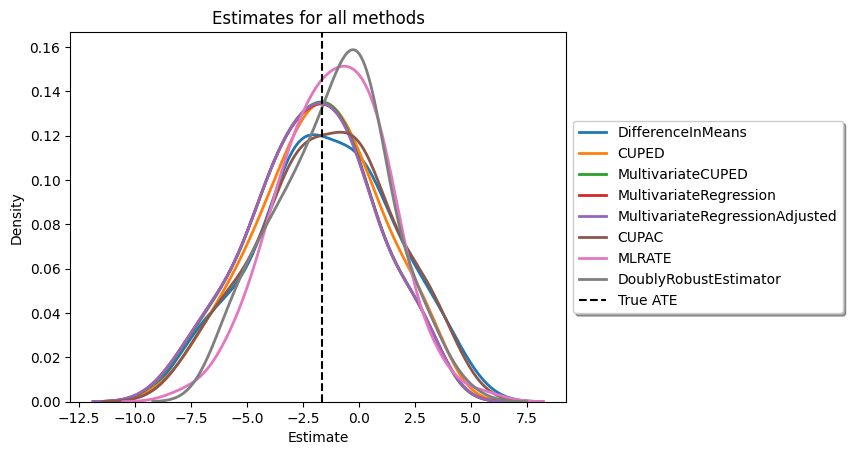

<Axes: title={'center': 'Estimates for all methods'}, xlabel='Estimate', ylabel='Density'>

In [84]:
evaluator_all5.plot(plot_what='estimates')

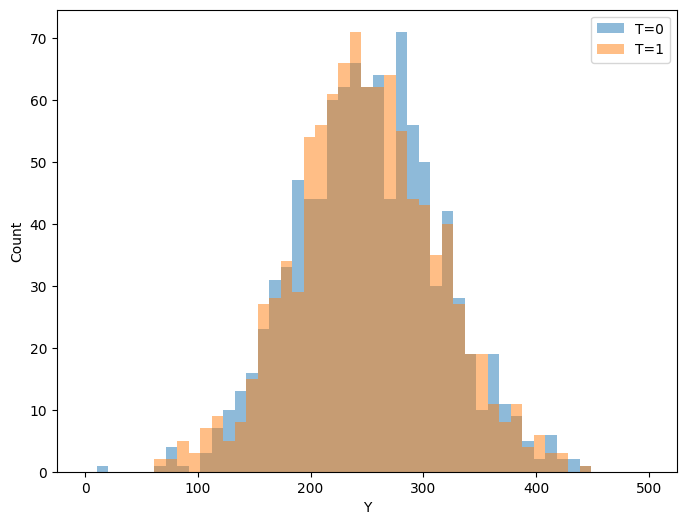

In [85]:
Y_0 = nonlinear_synthetic_df.loc[nonlinear_synthetic_df['T'] == 0]['Y']
Y_1 = nonlinear_synthetic_df.loc[nonlinear_synthetic_df['T'] == 1]['Y']

bins = np.linspace(0,500, 50)

# plot histogram
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(Y_0, bins=bins, alpha=0.5, label='T=0')
ax.hist(Y_1, bins=bins, alpha=0.5, label='T=1')
ax.set_xlabel('Y')
ax.set_ylabel('Count')
ax.legend()
plt.show()


In [86]:
nonlinear_synthetic_df.loc[nonlinear_synthetic_df['T'] == 1, 'Y'].mean() - nonlinear_synthetic_df.loc[nonlinear_synthetic_df['T'] == 0, 'Y'].mean()

-1.6425781

### MLRATE

In [87]:
mlrate_params_map = {
    
    'DifferenceInMeans':{

    },

    'MultivariateRegressionAdjusted': {
        'covariate_columns': nonlinear_synthetic_df.columns.to_list()[5:10]
    },

    'MLRATE': {
        'K_splits': 2,
        'covariate_columns': nonlinear_synthetic_df.columns.to_list()[5:10],
        'model': LGBMRegressor,
        'model_init_config': {
            # 'reg_lambda':0.005
            # 'max_depth':100
        },
        'model_fit_config': {
            # 'task': 'regression',
            # 'metric': 'mse',
            # 'time_budget': 60,
        }
    },
}

In [88]:
evaluation_mlrate = VREvaluationAll([DifferenceInMeans, MultivariateRegressionAdjusted, MLRATE])
evaluation_mlrate = evaluation_mlrate.run_all(data=nonlinear_synthetic_df,
                       target_column='Y',
                       treatment_column='T',
                       method_params_map=mlrate_params_map,
                       verbose=True,
                       n_bootstrap=100,
                       true_ate=-5)

Running DifferenceInMeans...


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1107.84it/s]


Running MultivariateRegressionAdjusted...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 121.92it/s]


Running MLRATE...


  1%|▍                                          | 1/100 [00:00<00:12,  7.93it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 253.520161
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 252.018501
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1272
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

  3%|█▎                                         | 3/100 [00:00<00:14,  6.75it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 251.310042
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 250.961818
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

  5%|██▏                                        | 5/100 [00:00<00:12,  7.32it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 250.054990
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 249.546711
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

  7%|███                                        | 7/100 [00:00<00:12,  7.69it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 252.761298
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 248.717714
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

  9%|███▊                                       | 9/100 [00:01<00:12,  7.46it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 252.771888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 253.107306
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 11%|████▌                                     | 11/100 [00:01<00:11,  7.74it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 249.772536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 253.429974
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 13%|█████▍                                    | 13/100 [00:01<00:10,  8.18it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1272
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 249.744687
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 249.321397
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 15%|██████▎                                   | 15/100 [00:02<00:11,  7.45it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1271
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 246.388069
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 250.432979
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 17%|███████▏                                  | 17/100 [00:02<00:11,  7.06it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 254.105002
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 252.865375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 18%|███████▌                                  | 18/100 [00:02<00:11,  7.20it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 251.914341
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 250.230295
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 20%|████████▍                                 | 20/100 [00:02<00:10,  7.40it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1272
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 252.302924
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 250.354157
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 22%|█████████▏                                | 22/100 [00:02<00:10,  7.68it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1272
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 251.929640
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 251.755854
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 24%|██████████                                | 24/100 [00:03<00:09,  7.83it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 249.666903
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 252.853883
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 25%|██████████▌                               | 25/100 [00:03<00:09,  7.61it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 250.303410
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 253.955785


 26%|██████████▉                               | 26/100 [00:03<00:17,  4.21it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 250.516725


 27%|███████████▎                              | 27/100 [00:04<00:23,  3.14it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 247.999543
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 253.828149


 28%|███████████▊                              | 28/100 [00:04<00:22,  3.25it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 253.959036
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 248.692383
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 30%|████████████▌                             | 30/100 [00:04<00:15,  4.55it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 248.231740
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 252.149839
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 32%|█████████████▍                            | 32/100 [00:05<00:12,  5.54it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 252.333505
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1272
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 249.904781
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 34%|██████████████▎                           | 34/100 [00:05<00:10,  6.45it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 249.707597
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 252.201124
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 36%|███████████████                           | 36/100 [00:05<00:09,  7.07it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 248.476176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 250.354962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 38%|███████████████▉                          | 38/100 [00:06<00:08,  7.02it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1272
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 252.640519
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 249.738358
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1272
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 40%|████████████████▊                         | 40/100 [00:06<00:07,  7.54it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1272
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 250.751504
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 251.972118
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 42%|█████████████████▋                        | 42/100 [00:06<00:07,  7.61it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 252.239672
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 251.948907
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 44%|██████████████████▍                       | 44/100 [00:06<00:06,  8.30it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 252.240047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 250.365132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1272
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 46%|███████████████████▎                      | 46/100 [00:06<00:06,  8.44it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 247.555584
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 249.700198
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 47%|███████████████████▋                      | 47/100 [00:07<00:06,  8.37it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 252.648677
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 255.722185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 48%|████████████████████▏                     | 48/100 [00:07<00:07,  6.58it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 251.923294
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 255.908182


 50%|█████████████████████                     | 50/100 [00:07<00:08,  5.79it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 254.639662
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 256.504887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 51%|█████████████████████▍                    | 51/100 [00:07<00:07,  6.20it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1272
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 251.716449
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 253.166042
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1272
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 53%|██████████████████████▎                   | 53/100 [00:08<00:06,  7.03it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 250.479490
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 250.239482
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 55%|███████████████████████                   | 55/100 [00:08<00:05,  7.60it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 250.848319
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 247.434740
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 57%|███████████████████████▉                  | 57/100 [00:08<00:05,  7.78it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 251.701959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 250.335733
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 59%|████████████████████████▊                 | 59/100 [00:08<00:04,  8.67it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 251.007404
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 253.283723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 61%|█████████████████████████▌                | 61/100 [00:09<00:05,  7.55it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 248.344906
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 252.155340
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 63%|██████████████████████████▍               | 63/100 [00:09<00:04,  7.90it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 252.991862
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 250.639612
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 65%|███████████████████████████▎              | 65/100 [00:09<00:04,  7.96it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 251.905946
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 250.511880
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 67%|████████████████████████████▏             | 67/100 [00:09<00:03,  8.30it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 248.197506
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 248.259027
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 69%|████████████████████████████▉             | 69/100 [00:10<00:03,  8.51it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 252.693557
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 250.764938
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 71%|█████████████████████████████▊            | 71/100 [00:10<00:03,  8.83it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 252.927282
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 248.544521
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 73%|██████████████████████████████▋           | 73/100 [00:10<00:02,  9.31it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 251.583713
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1272
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 249.842693
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 74%|███████████████████████████████           | 74/100 [00:10<00:02,  9.43it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 247.852697
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 253.550957
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 78%|████████████████████████████████▊         | 78/100 [00:10<00:02,  9.78it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 252.548466
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1272
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 251.523713
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1272
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 80%|█████████████████████████████████▌        | 80/100 [00:11<00:02,  9.34it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 252.751048
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 248.763575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 82%|██████████████████████████████████▍       | 82/100 [00:11<00:01,  9.14it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 250.263211
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 255.148740
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 84%|███████████████████████████████████▎      | 84/100 [00:11<00:01,  8.97it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 251.225198
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 253.765036
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 86%|████████████████████████████████████      | 86/100 [00:11<00:01,  8.92it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 250.855252
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1272
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 251.500639
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 87%|████████████████████████████████████▌     | 87/100 [00:12<00:01,  8.65it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 249.890272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 248.878966
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 89%|█████████████████████████████████████▍    | 89/100 [00:12<00:01,  7.97it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1272
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 251.192552
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 247.939502
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 90%|█████████████████████████████████████▊    | 90/100 [00:12<00:01,  8.13it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 252.692024
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 252.781083
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 94%|███████████████████████████████████████▍  | 94/100 [00:12<00:00,  9.21it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 245.697200
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 251.521564
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 95%|███████████████████████████████████████▉  | 95/100 [00:12<00:00,  8.88it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 253.035268
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 249.562633
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 97%|████████████████████████████████████████▋ | 97/100 [00:13<00:00,  8.67it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1272
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 247.447268
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 252.820609
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

 99%|█████████████████████████████████████████▌| 99/100 [00:13<00:00,  8.44it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 252.785470
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 254.170300
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start train

100%|█████████████████████████████████████████| 100/100 [00:13<00:00,  7.39it/s]

Done!


In [89]:
evaluation_mlrate.report()

,Method,Estimate,Estimate CI,Bias,Bias CI,p-value,p-value CI,Coverage Probability,Variance Reduction
0,DifferenceInMeans,-1.331140,"(-6.992804471778603, 4.158807782745644)",3.668860,"(-1.9928044717786038, 9.158807782745644)",0.499334,"(0.016236703046643326, 0.9834643112185083)",0.00,0.000000
1,MultivariateRegressionAdjusted,-1.554620,"(-7.148486855575806, 3.898832257864292)",3.445380,"(-2.1484868555758054, 8.89883225786429)",0.487338,"(0.014008807598943435, 0.9732432296109342)",0.79,0.011646
2,MLRATE,-1.029025,"(-5.573520260132752, 4.437317392125501)",3.970975,"(-0.5735202601327518, 9.437317392125502)",0.496378,"(0.026210455912286962, 0.9847403747476994)",0.66,0.216932


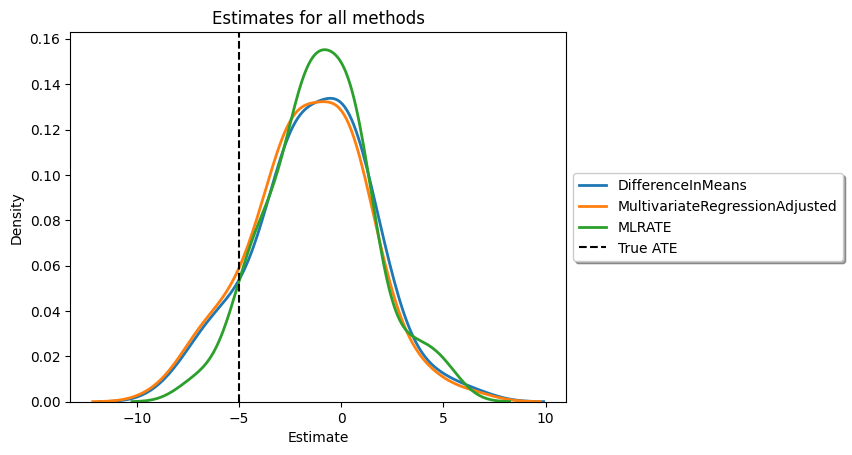

<Axes: title={'center': 'Estimates for all methods'}, xlabel='Estimate', ylabel='Density'>

In [90]:
evaluation_mlrate.plot(plot_what='estimates')

In [92]:
# evaluation_mlrate.evaluations['MLRATE'].estimators[10]._diag['g_k_scores']

## MLRATE paper data

In [93]:
def b(X_i):

    return 10 * np.sin(np.pi * X_i[:, 0] * X_i[:, 1]) \
             + 20 * (X_i[:, 2] - 0.5)**2 \
             +10 * X_i[:, 3] + 5 * X_i[:, 4]

def tau(X_i):

    return X_i[:, 0] + np.log(1 + np.exp(X_i[:, 1]))

def mlrate_synthetic(N=10000, p=0.5):

    X = np.random.multivariate_normal(np.zeros(100), np.identity(100), N)
    T = np.random.binomial(1, p, N)

    Y = b(X) + T * tau(X) + np.random.normal(0, 25, N)

    X_df = pd.DataFrame(X).add_prefix("X_")

    df_columns = {"Y": Y, "T": T}

    df = pd.DataFrame(df_columns)
    df = pd.merge(df, X_df, left_index=True, right_index=True)

    return df

In [94]:
mlrate_synthetic_df = mlrate_synthetic(N=5000)

In [95]:
mlrate_synthetic_df.columns
mlrate_covariates = mlrate_synthetic_df.columns.tolist()[2:]

In [96]:
method_params_map7 = {

    'DifferenceInMeans': {
    },
    
    'CUPED': {
        'covariate_column': mlrate_covariates[0]
    },

    'MultivariateCUPED': {
        'covariate_columns': mlrate_covariates
    },

    'MultivariateRegression': {
        'covariate_columns': mlrate_covariates
    },

    'MultivariateRegressionAdjusted': {
        'covariate_columns': mlrate_covariates
    },


    # 'CUPAC': {
    #     'pre_experiment_data': 'ml_synthetic_df',
    #     'covariate_columns': list(ml_synthetic_df.columns[2:10]),
    #     'model': HistGradientBoostingRegressor,
    #     'model_init_config': {},
    #     'model_fit_config': {}
    # },

    'MLRATE': {
        'K_splits': 2,
        'covariate_columns': mlrate_covariates,
        'model': LGBMRegressor,
        'model_init_config': {},
        'model_fit_config': {}
    },

    'DoublyRobustEstimator': {
        'covariate_columns': mlrate_covariates,
        'model_regression': LGBMRegressor,
        'model_propensity': 'auto',
    }

}

In [97]:
evaluator_all7 = VREvaluationAll([DifferenceInMeans, 
                                 MultivariateRegression,
                                 MultivariateRegressionAdjusted,
                                 CUPED, 
                                 MultivariateCUPED,
                                 MLRATE, 
                                 DoublyRobustEstimator])

evaluator_all7.run_all(data=mlrate_synthetic_df,
                       treatment_column='T',
                       target_column='Y',
                       method_params_map=method_params_map7,
                       verbose=True,
                       n_bootstrap=100,
                       true_ate=diff_in_means(mlrate_synthetic_df, 'T', 'Y'))

Running DifferenceInMeans...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 500.52it/s]


Running MultivariateRegression...


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 12.03it/s]


Running MultivariateRegressionAdjusted...


100%|█████████████████████████████████████████| 100/100 [00:21<00:00,  4.73it/s]


Running CUPED...


 15%|██████▏                                  | 15/100 [00:00<00:00, 142.71it/s]

[25.62683822  0.12301212]
[23.9631723  -0.17250816]
[24.69146646 -0.07789054]
[25.53760866 -0.73906234]
[25.65741393  0.49367296]
[24.36008252  0.17755898]
[25.36091948 -0.48801263]
[25.05559859 -0.4857149 ]
[26.19394088 -0.58202962]
[24.86643255 -0.0873102 ]
[25.70832291  0.53002469]
[25.46635584  0.58280843]
[25.03652798  0.60039872]
[24.64785605  0.88883076]
[25.00543954  0.40829442]
[23.96916839  0.19352535]
[25.65587626  0.79797514]
[23.92159761 -0.54707163]
[24.54072005  0.28993306]
[25.30398119  0.48158064]
[25.2975616   0.66204248]
[26.49232762  0.76180201]
[2.40399420e+01 7.89152695e-03]
[25.36547258  0.37111004]
[24.90673945 -0.63771526]
[24.71672857  0.96660143]
[25.96817257  0.7357291 ]
[24.7943572   0.05080228]
[25.99250379  0.34452204]


 45%|██████████████████▍                      | 45/100 [00:00<00:00, 144.68it/s]

[26.06002907  0.07106929]
[25.13710502  0.37652722]
[25.33848024  0.36221922]
[26.00631429  0.67711121]
[25.19326828  0.11333587]
[24.36779682 -1.02222337]
[25.99199346  0.02918534]
[24.76681633 -0.96468927]
[24.79459257  0.43661755]
[25.57912192  0.90543193]
[25.41715879 -1.02525647]
[25.52119484  0.57768164]
[25.60026883  0.8934688 ]
[25.02703612 -0.61427029]
[25.08443908 -0.20862695]
[26.01982836 -0.25366929]
[25.68592559 -0.6163383 ]
[2.55208210e+01 2.49643052e-02]
[25.55335213  0.27191966]
[26.55543653  1.90940272]
[25.44035742 -0.90282031]
[25.79174525 -0.38868649]
[25.3584677   0.11030613]
[25.8410813   0.74878131]
[25.74984534 -0.25493832]
[24.96995887 -0.19123228]
[25.0636668   0.25440629]
[24.86849656 -1.18559237]
[26.54035988 -0.27071912]
[26.23290258  0.15826184]


 75%|██████████████████████████████▊          | 75/100 [00:00<00:00, 146.17it/s]

[24.35273719 -1.79385131]
[24.56856136  0.35060101]
[24.33881734 -0.16394006]
[25.35234119 -0.08163565]
[25.75822977  0.43477487]
[26.65822989  1.42787977]
[24.33465859 -0.04668425]
[24.63106107  0.13832855]
[24.84045663 -0.18432934]
[25.39522447  0.88068709]
[25.66491123 -0.16644509]
[25.87047491 -0.16883238]
[25.55592398  0.7298873 ]
[25.51301305  0.50043347]
[25.97719441 -0.20835163]
[24.994618    1.01630593]
[24.73284216  0.09260472]
[25.68685635  0.64431392]
[25.34404964 -0.34127899]
[25.17544804 -0.42445681]
[24.89184367 -0.54895939]
[26.47302425 -0.64001167]
[25.24728585  0.70427911]
[24.9018806  -0.22377537]
[25.39263391  1.26203934]
[25.39517171  0.83847771]
[25.44073876  0.51504775]
[25.45384284  0.67164578]
[26.25106277  0.51874155]
[26.55280778  0.12581909]


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 144.64it/s]


[25.52738199  1.20695527]
[25.02583461 -0.95346854]
[26.58771568  0.48162997]
[25.48157308 -0.28414022]
[24.71013851 -0.03975513]
[24.59717336  0.13824065]
[2.48605709e+01 1.57434461e-02]
[26.19919725 -0.2229201 ]
[25.56573436 -0.20403932]
[24.94914678  0.61781956]
[23.933421   -0.07854175]
Running MultivariateCUPED...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 63.09it/s]


Running MLRATE...


  0%|                                                   | 0/100 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.533261
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.713103


  1%|▍                                          | 1/100 [00:00<00:51,  1.94it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.899010
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 23.025687


  2%|▊                                          | 2/100 [00:01<00:50,  1.94it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 23.973655
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.410520


  3%|█▎                                         | 3/100 [00:01<00:49,  1.97it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.514894
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.577609


  4%|█▋                                         | 4/100 [00:02<00:52,  1.82it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.100709
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.214670


  5%|██▏                                        | 5/100 [00:02<00:51,  1.86it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 23.743902
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.979597


  6%|██▌                                        | 6/100 [00:03<00:48,  1.93it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.177603
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.559074


  7%|███                                        | 7/100 [00:03<00:50,  1.83it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 23.864093
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.241402


  8%|███▍                                       | 8/100 [00:04<00:50,  1.84it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.968780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.401845


  9%|███▊                                       | 9/100 [00:05<00:54,  1.65it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.870969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.860117


 10%|████▏                                     | 10/100 [00:05<00:56,  1.59it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.130407
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.286406


 11%|████▌                                     | 11/100 [00:06<00:52,  1.69it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.744455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.169340


 12%|█████                                     | 12/100 [00:06<00:51,  1.71it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.459402
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.620374


 13%|█████▍                                    | 13/100 [00:07<00:51,  1.69it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.952470
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 23.339371


 14%|█████▉                                    | 14/100 [00:07<00:51,  1.68it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.699139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.315155


 15%|██████▎                                   | 15/100 [00:08<00:50,  1.69it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.399581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 23.537595


 16%|██████▋                                   | 16/100 [00:09<00:49,  1.71it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.498668
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.798864


 17%|███████▏                                  | 17/100 [00:09<00:51,  1.61it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 23.546854
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.327321


 18%|███████▌                                  | 18/100 [00:10<00:48,  1.70it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.587595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.497216


 19%|███████▉                                  | 19/100 [00:10<00:45,  1.78it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.391916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.196744


 20%|████████▍                                 | 20/100 [00:11<00:43,  1.86it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.158478
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.448446


 21%|████████▊                                 | 21/100 [00:11<00:40,  1.96it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.460107
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.538486


 22%|█████████▏                                | 22/100 [00:12<00:53,  1.46it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.813773
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 23.266042


 23%|█████████▋                                | 23/100 [00:13<00:50,  1.54it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.211653
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.530923


 24%|██████████                                | 24/100 [00:13<00:45,  1.65it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.259680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.553267


 25%|██████████▌                               | 25/100 [00:14<00:42,  1.77it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.309173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.143960


 26%|██████████▉                               | 26/100 [00:14<00:39,  1.88it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.994508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.915676


 27%|███████████▎                              | 27/100 [00:15<00:36,  1.98it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.476488
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.112686


 28%|███████████▊                              | 28/100 [00:15<00:34,  2.06it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.342358
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.642107


 29%|████████████▏                             | 29/100 [00:16<00:33,  2.11it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.337851
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.781397


 30%|████████████▌                             | 30/100 [00:16<00:32,  2.13it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.605795
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.671552


 31%|█████████████                             | 31/100 [00:17<00:31,  2.17it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.478649
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.214787


 32%|█████████████▍                            | 32/100 [00:17<00:30,  2.20it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.687288
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.322718


 33%|█████████████▊                            | 33/100 [00:18<00:30,  2.20it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.658963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.730678


 34%|██████████████▎                           | 34/100 [00:18<00:29,  2.22it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.204201
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.521670


 35%|██████████████▋                           | 35/100 [00:18<00:29,  2.23it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.714955
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.269202


 36%|███████████████                           | 36/100 [00:19<00:28,  2.24it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.454323
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.073726


 37%|███████████████▌                          | 37/100 [00:19<00:28,  2.25it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.580768
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.001845


 38%|███████████████▉                          | 38/100 [00:20<00:27,  2.24it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.507267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.657427


 39%|████████████████▍                         | 39/100 [00:20<00:27,  2.23it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.882926
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.944229


 40%|████████████████▊                         | 40/100 [00:21<00:26,  2.24it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.651302
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.403052


 41%|█████████████████▏                        | 41/100 [00:21<00:26,  2.24it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.143858
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.034377


 42%|█████████████████▋                        | 42/100 [00:22<00:26,  2.23it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 23.675642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.366571


 43%|██████████████████                        | 43/100 [00:22<00:25,  2.24it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.486772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.684383


 44%|██████████████████▍                       | 44/100 [00:22<00:25,  2.23it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 27.401492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.641843


 45%|██████████████████▉                       | 45/100 [00:23<00:24,  2.23it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.310063
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.072658


 46%|███████████████████▎                      | 46/100 [00:23<00:24,  2.23it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.079896
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.961863


 47%|███████████████████▋                      | 47/100 [00:24<00:26,  1.99it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.603810
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.490912


 48%|████████████████████▏                     | 48/100 [00:25<00:29,  1.77it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 27.089154
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.034056


 49%|████████████████████▌                     | 49/100 [00:25<00:31,  1.63it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.354423
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.538226


 50%|█████████████████████                     | 50/100 [00:26<00:32,  1.55it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.615551
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.963869


 51%|█████████████████████▍                    | 51/100 [00:27<00:32,  1.50it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.843407
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.874898


 52%|█████████████████████▊                    | 52/100 [00:28<00:33,  1.43it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.131046
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.553322


 53%|██████████████████████▎                   | 53/100 [00:28<00:35,  1.31it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.781794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.727995


 54%|██████████████████████▋                   | 54/100 [00:29<00:34,  1.34it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 22.953597
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.983624


 55%|███████████████████████                   | 55/100 [00:30<00:32,  1.38it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.457810
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.663086


 56%|███████████████████████▌                  | 56/100 [00:31<00:31,  1.41it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.232991
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 23.535592


 57%|███████████████████████▉                  | 57/100 [00:31<00:27,  1.56it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 27.543268
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.535060


 58%|████████████████████████▎                 | 58/100 [00:32<00:26,  1.59it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.069460
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.393029


 59%|████████████████████████▊                 | 59/100 [00:33<00:29,  1.41it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.218751
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.427137


 60%|█████████████████████████▏                | 60/100 [00:33<00:29,  1.34it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.180539
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 23.968128


 61%|█████████████████████████▌                | 61/100 [00:35<00:38,  1.02it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.374671
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.301717


 62%|██████████████████████████                | 62/100 [00:36<00:33,  1.14it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.419813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.285652


 63%|██████████████████████████▍               | 63/100 [00:36<00:29,  1.26it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.716515
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.819177


 64%|██████████████████████████▉               | 64/100 [00:37<00:26,  1.36it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 27.479473
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.836799


 65%|███████████████████████████▎              | 65/100 [00:37<00:24,  1.40it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.661491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.006277


 66%|███████████████████████████▋              | 66/100 [00:38<00:27,  1.24it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.916688
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.351207


 67%|████████████████████████████▏             | 67/100 [00:39<00:25,  1.29it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.273242
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.409529


 68%|████████████████████████████▌             | 68/100 [00:40<00:21,  1.45it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.494295
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.326931


 69%|████████████████████████████▉             | 69/100 [00:40<00:21,  1.46it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.619005
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.715796


 70%|█████████████████████████████▍            | 70/100 [00:41<00:20,  1.45it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.996081
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.735136


 71%|█████████████████████████████▊            | 71/100 [00:42<00:20,  1.40it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.424602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.675804


 72%|██████████████████████████████▏           | 72/100 [00:43<00:21,  1.29it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.578933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.457676


 73%|██████████████████████████████▋           | 73/100 [00:43<00:19,  1.37it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.005056
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.945581


 74%|███████████████████████████████           | 74/100 [00:44<00:19,  1.33it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.914141
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.080070


 75%|███████████████████████████████▌          | 75/100 [00:45<00:19,  1.30it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.576084
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.888007


 76%|███████████████████████████████▉          | 76/100 [00:46<00:17,  1.37it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.423998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.915933


 77%|████████████████████████████████▎         | 77/100 [00:46<00:15,  1.51it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.281129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.416446


 78%|████████████████████████████████▊         | 78/100 [00:47<00:13,  1.63it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.373741
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.966344


 79%|█████████████████████████████████▏        | 79/100 [00:47<00:12,  1.72it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.003067
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.747074


 80%|█████████████████████████████████▌        | 80/100 [00:48<00:11,  1.81it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.937699
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.033405


 81%|██████████████████████████████████        | 81/100 [00:48<00:10,  1.90it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.760304
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.705690


 82%|██████████████████████████████████▍       | 82/100 [00:48<00:09,  1.97it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.500635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.307182


 83%|██████████████████████████████████▊       | 83/100 [00:49<00:08,  1.90it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.653397
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.054399


 84%|███████████████████████████████████▎      | 84/100 [00:49<00:08,  1.98it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.303665
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.427919


 85%|███████████████████████████████████▋      | 85/100 [00:50<00:07,  2.06it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.756537
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.098385


 86%|████████████████████████████████████      | 86/100 [00:50<00:06,  2.07it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.677662
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.248386


 87%|████████████████████████████████████▌     | 87/100 [00:51<00:06,  1.95it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.190482
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 27.315128


 88%|████████████████████████████████████▉     | 88/100 [00:52<00:06,  1.94it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.377579
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.725937


 89%|█████████████████████████████████████▍    | 89/100 [00:52<00:06,  1.76it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.028735
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.023814


 90%|█████████████████████████████████████▊    | 90/100 [00:53<00:05,  1.76it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.004372
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.056295


 91%|██████████████████████████████████████▏   | 91/100 [00:53<00:04,  1.87it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.698342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.479768


 92%|██████████████████████████████████████▋   | 92/100 [00:54<00:04,  1.91it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.635333
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.310830


 93%|███████████████████████████████████████   | 93/100 [00:54<00:03,  1.95it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.328007
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.093234


 94%|███████████████████████████████████████▍  | 94/100 [00:55<00:03,  1.97it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.272882
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 23.926514


 95%|███████████████████████████████████████▉  | 95/100 [00:55<00:02,  2.01it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 25.357965
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.363162


 96%|████████████████████████████████████████▎ | 96/100 [00:56<00:02,  1.92it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.019409
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.381680


 97%|████████████████████████████████████████▋ | 97/100 [00:56<00:01,  1.85it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.871178
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 26.264054


 98%|█████████████████████████████████████████▏| 98/100 [00:57<00:01,  1.85it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.939347
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.932153


 99%|█████████████████████████████████████████▌| 99/100 [00:57<00:00,  1.94it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 23.383843
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 100
[LightGBM] [Info] Start training from score 24.484271


100%|█████████████████████████████████████████| 100/100 [00:58<00:00,  1.72it/s]


Running DoublyRobustEstimator...


  0%|                                                   | 0/100 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.630988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.615377


  1%|▍                                          | 1/100 [00:00<01:04,  1.53it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 23.619906
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.304791


  2%|▊                                          | 2/100 [00:01<01:03,  1.56it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.418410
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 23.965765


  3%|█▎                                         | 3/100 [00:02<01:25,  1.14it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.986590
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.105913


  4%|█▋                                         | 4/100 [00:03<01:21,  1.18it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.361712
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.953667


  5%|██▏                                        | 5/100 [00:03<01:13,  1.30it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.785864
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 23.937634


  6%|██▌                                        | 6/100 [00:04<01:08,  1.38it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.028745
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.707932


  7%|███                                        | 7/100 [00:05<01:04,  1.44it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.946259
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.159236


  8%|███▍                                       | 8/100 [00:05<01:04,  1.43it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.228406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.142218


  9%|███▊                                       | 9/100 [00:06<01:02,  1.45it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 23.015535
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.715552


 10%|████▏                                     | 10/100 [00:07<01:01,  1.47it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.201598
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.215214


 11%|████▌                                     | 11/100 [00:07<01:00,  1.47it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.740648
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.173147


 12%|█████                                     | 12/100 [00:08<00:58,  1.50it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.583032
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.496743


 13%|█████▍                                    | 13/100 [00:09<00:58,  1.47it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.540310
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 23.751531


 14%|█████▉                                    | 14/100 [00:09<00:58,  1.46it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.720584
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.293710


 15%|██████▎                                   | 15/100 [00:10<01:06,  1.27it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 23.652564
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.284612


 16%|██████▋                                   | 16/100 [00:11<01:03,  1.33it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.119362
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.178171


 17%|███████▏                                  | 17/100 [00:12<01:05,  1.27it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 23.500618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.373557


 18%|███████▌                                  | 18/100 [00:13<01:01,  1.33it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.425245
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.659566


 19%|███████▉                                  | 19/100 [00:13<01:00,  1.34it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.828533
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.760128


 20%|████████▍                                 | 20/100 [00:14<00:57,  1.38it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.165649
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.441275


 21%|████████▊                                 | 21/100 [00:15<00:59,  1.33it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.589379
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.409215


 22%|█████████▏                                | 22/100 [00:16<00:57,  1.37it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 21.947590
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.132225


 23%|█████████▋                                | 23/100 [00:16<00:54,  1.42it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.350223
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.392353


 24%|██████████                                | 24/100 [00:17<00:52,  1.44it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.285958
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.526988


 25%|██████████▌                               | 25/100 [00:18<01:02,  1.20it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.381323
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.071810


 26%|██████████▉                               | 26/100 [00:19<01:01,  1.20it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.853678
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.056507


 27%|███████████▎                              | 27/100 [00:20<01:00,  1.20it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.751373
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.837801


 28%|███████████▊                              | 28/100 [00:20<00:59,  1.21it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.677653
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 27.306812


 29%|████████████▏                             | 29/100 [00:21<00:56,  1.26it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.031096
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 27.088152


 30%|████████████▌                             | 30/100 [00:22<00:53,  1.30it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.131478
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.145869


 31%|█████████████                             | 31/100 [00:23<00:51,  1.33it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.077444
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.615992


 32%|█████████████▍                            | 32/100 [00:23<00:50,  1.35it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.530643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 27.479363


 33%|█████████████▊                            | 33/100 [00:24<00:50,  1.34it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.947784
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.441857


 34%|██████████████▎                           | 34/100 [00:25<00:55,  1.18it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.209895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.515976


 35%|██████████████▋                           | 35/100 [00:26<00:57,  1.14it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.077810
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.906347


 36%|███████████████                           | 36/100 [00:27<00:57,  1.11it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.321109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.206940


 37%|███████████████▌                          | 37/100 [00:28<00:53,  1.18it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.344882
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.237732


 38%|███████████████▉                          | 38/100 [00:29<00:51,  1.22it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.968274
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.196419


 39%|████████████████▍                         | 39/100 [00:29<00:49,  1.23it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.350620
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.476535


 40%|████████████████▊                         | 40/100 [00:30<00:46,  1.28it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.043164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.011189


 41%|█████████████████▏                        | 41/100 [00:31<00:44,  1.31it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.485164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.693071


 42%|█████████████████▋                        | 42/100 [00:32<00:44,  1.31it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 23.909061
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.133152


 43%|██████████████████                        | 43/100 [00:32<00:43,  1.30it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.671018
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.500137


 44%|██████████████████▍                       | 44/100 [00:33<00:42,  1.32it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 27.245774
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.797561


 45%|██████████████████▉                       | 45/100 [00:34<00:51,  1.08it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.316751
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.065970


 46%|███████████████████▎                      | 46/100 [00:35<00:45,  1.18it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.997524
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.044235


 47%|███████████████████▋                      | 47/100 [00:36<00:42,  1.25it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.101165
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.993557


 48%|████████████████████▏                     | 48/100 [00:36<00:40,  1.28it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.953781
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.169428


 49%|████████████████████▌                     | 49/100 [00:37<00:38,  1.33it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.297429
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.595219


 50%|█████████████████████                     | 50/100 [00:38<00:36,  1.38it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.223861
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.355559


 51%|█████████████████████▍                    | 51/100 [00:39<00:35,  1.37it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.190893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.527413


 52%|█████████████████████▊                    | 52/100 [00:39<00:35,  1.37it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.270551
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.413816


 53%|██████████████████████▎                   | 53/100 [00:40<00:33,  1.39it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.921161
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.588628


 54%|██████████████████████▋                   | 54/100 [00:41<00:33,  1.37it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.626169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.311052


 55%|███████████████████████                   | 55/100 [00:41<00:32,  1.40it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.228689
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 23.892206


 56%|███████████████████████▌                  | 56/100 [00:42<00:31,  1.40it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.037855
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.730728


 57%|███████████████████████▉                  | 57/100 [00:43<00:30,  1.41it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.468474
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.609854


 58%|████████████████████████▎                 | 58/100 [00:44<00:29,  1.41it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.219988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.242501


 59%|████████████████████████▊                 | 59/100 [00:44<00:29,  1.39it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.544120
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.101768


 60%|█████████████████████████▏                | 60/100 [00:45<00:28,  1.40it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.506283
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.642384


 61%|█████████████████████████▌                | 61/100 [00:46<00:27,  1.42it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.704624
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 23.971764


 62%|██████████████████████████                | 62/100 [00:46<00:26,  1.43it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.496047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.209418


 63%|██████████████████████████▍               | 63/100 [00:47<00:25,  1.45it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.175488
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 27.360204


 64%|██████████████████████████▉               | 64/100 [00:48<00:25,  1.39it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.847544
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.468728


 65%|███████████████████████████▎              | 65/100 [00:49<00:25,  1.39it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.660536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 23.007232


 66%|███████████████████████████▋              | 66/100 [00:49<00:24,  1.41it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.275888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.992006


 67%|████████████████████████████▏             | 67/100 [00:50<00:27,  1.21it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.964051
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.718721


 68%|████████████████████████████▌             | 68/100 [00:51<00:24,  1.29it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.664149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.157076


 69%|████████████████████████████▉             | 69/100 [00:52<00:22,  1.35it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 23.960666
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 27.374135


 70%|█████████████████████████████▍            | 70/100 [00:52<00:21,  1.41it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.773503
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.957713


 71%|█████████████████████████████▊            | 71/100 [00:53<00:19,  1.45it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.016909
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.083498


 72%|██████████████████████████████▏           | 72/100 [00:54<00:18,  1.47it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.561902
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.474707


 73%|██████████████████████████████▋           | 73/100 [00:54<00:18,  1.44it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.415569
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.535068


 74%|███████████████████████████████           | 74/100 [00:55<00:18,  1.43it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.054565
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.939646


 75%|███████████████████████████████▌          | 75/100 [00:56<00:17,  1.45it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.680467
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.783624


 76%|███████████████████████████████▉          | 76/100 [00:56<00:16,  1.43it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.791254
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.548677


 77%|████████████████████████████████▎         | 77/100 [00:57<00:15,  1.47it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.952499
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.745075


 78%|████████████████████████████████▊         | 78/100 [00:58<00:15,  1.42it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.424406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.915679


 79%|█████████████████████████████████▏        | 79/100 [00:59<00:15,  1.40it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.457728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.292412


 80%|█████████████████████████████████▌        | 80/100 [00:59<00:15,  1.27it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.913266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 27.057838


 81%|██████████████████████████████████        | 81/100 [01:00<00:15,  1.27it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.021981
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.444013


 82%|██████████████████████████████████▍       | 82/100 [01:01<00:14,  1.28it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.585717
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.222101


 83%|██████████████████████████████████▊       | 83/100 [01:02<00:12,  1.32it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.025564
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.682232


 84%|███████████████████████████████████▎      | 84/100 [01:02<00:11,  1.36it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.017454
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.714130


 85%|███████████████████████████████████▋      | 85/100 [01:03<00:10,  1.40it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.838068
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.016854


 86%|████████████████████████████████████      | 86/100 [01:04<00:10,  1.34it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.529955
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.396093


 87%|████████████████████████████████████▌     | 87/100 [01:05<00:09,  1.36it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.003098
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 27.502511


 88%|████████████████████████████████████▉     | 88/100 [01:06<00:09,  1.24it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.279992
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.823524


 89%|█████████████████████████████████████▍    | 89/100 [01:07<00:09,  1.14it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.412138
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.640411


 90%|█████████████████████████████████████▊    | 90/100 [01:07<00:08,  1.21it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.926230
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.134437


 91%|██████████████████████████████████████▏   | 91/100 [01:08<00:07,  1.16it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 27.046631
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.131480


 92%|██████████████████████████████████████▋   | 92/100 [01:09<00:07,  1.13it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.519315
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.426848


 93%|███████████████████████████████████████   | 93/100 [01:10<00:06,  1.13it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 23.981484
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.439756


 94%|███████████████████████████████████████▍  | 94/100 [01:11<00:05,  1.19it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.351451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.847945


 95%|███████████████████████████████████████▉  | 95/100 [01:12<00:04,  1.24it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.781844
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.939283


 96%|████████████████████████████████████████▎ | 96/100 [01:12<00:03,  1.28it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.218147
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.182942


 97%|████████████████████████████████████████▋ | 97/100 [01:13<00:02,  1.24it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 26.711632
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.423601


 98%|█████████████████████████████████████████▏| 98/100 [01:14<00:01,  1.29it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.335068
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 25.536432


 99%|█████████████████████████████████████████▌| 99/100 [01:15<00:00,  1.36it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 24.218125
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25502
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 101
[LightGBM] [Info] Start training from score 23.649989


100%|█████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]

Done!


In [98]:
evaluator_all7.report()

,Method,Estimate,Estimate CI,Bias,Bias CI,p-value,p-value CI,Coverage Probability,Variance Reduction
0,DifferenceInMeans,1.233260,"(-1.5036896876461512, 3.90080725185109)",0.056997,"(-2.679952819543054, 2.7245441199541873)",0.339887,"(0.0021766802953604165, 0.8988573616489238)",0.00,0.000000
1,MultivariateRegression,2.004934,"(-0.3227470295186313, 3.9214077854941287)",0.828671,"(-1.499010161415534, 2.745144653597226)",0.188607,"(0.00038123922017009316, 0.7875609633858877)",0.88,0.335812
2,MultivariateRegressionAdjusted,1.988555,"(-0.26853887215616695, 3.8412975054108434)",0.812292,"(-1.4448020040530698, 2.6650343735139406)",0.19218,"(0.00042537436933735845, 0.7978265176207493)",0.90,0.336320
3,CUPED,1.237320,"(-1.4558492645213912, 3.938150016994154)",0.061057,"(-2.632112396418294, 2.761886885097251)",0.340906,"(0.0019670575133439207, 0.9223249647874422)",0.93,0.005896
4,MultivariateCUPED,1.934300,"(-0.31158179562337074, 3.7913953614843656)",0.758037,"(-1.4878449275202734, 2.615132229587463)",0.190571,"(0.0004174393128669127, 0.7895695524103769)",0.89,0.380369
5,MLRATE,1.749487,"(0.7309248924479634, 2.794816966176923)",0.573224,"(-0.44533823944893935, 1.6185538342800203)",0.03423,"(9.41285931036341e-06, 0.24924961011459237)",0.91,0.861413
6,DoublyRobustEstimator,2.001336,"(0.8838187360485661, 3.2533745699355623)",0.825073,"(-0.29244439584833665, 2.0771114380386595)",None,None,0.77,0.763479


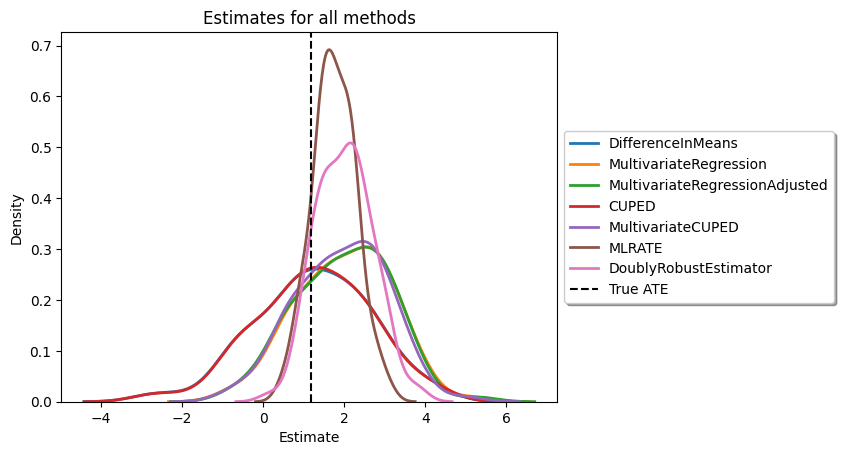

<Axes: title={'center': 'Estimates for all methods'}, xlabel='Estimate', ylabel='Density'>

In [99]:
evaluator_all7.plot(plot_what='estimates')